In [1]:
import os
import seaborn as sns
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from scipy.stats import linregress
import warnings
warnings.filterwarnings('ignore')

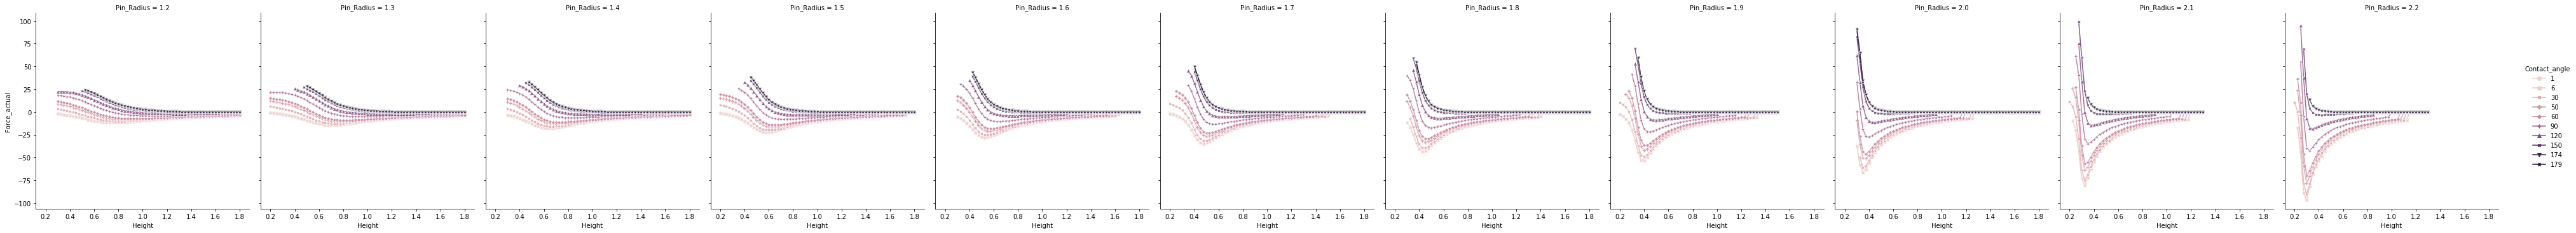

In [2]:
folderpath = 'E:/Work/Surface Evolver/Data/Bubble_Bridge/20210716 model data all/'
simu_df = pd.DataFrame()
with os.scandir(folderpath) as folder_main:    
    for subfolder in folder_main:
        if subfolder.is_dir():            
            simu_folderpath = subfolder.path
            with os.scandir(simu_folderpath) as folder:
                rupture_path = simu_folderpath + '/rupture.txt'
                df_rupture = pd.read_csv(rupture_path,delimiter='\t')
                for file in folder:
                    if file.is_file() and file.path.endswith( ('.txt') ) and file.name != 'rupture.txt':
                        df_temp = pd.read_csv(file.path,delimiter='\t')
                        height_range = df_rupture[df_rupture['Angle'] == df_temp['Bottom_Angle'].iloc[0]]
                        rupture_height = height_range['Rupture_Height'].iloc[0]
                        start_height = height_range['Start_Height'].iloc[0]
                        df_temp['Force_corrected1'] = np.where(df_temp['Height'] > rupture_height, 
                                                              0, df_temp['Force_Calc'])
                        df_temp['Force_corrected2'] = np.where(df_temp['Height'] < start_height, 
                                                              np.nan, df_temp['Force_corrected1'])
                        df_temp['Bottom_Area_corrected'] = np.where(df_temp['Height'] > rupture_height, 
                                                              0, df_temp['Bottom_Area'])
                        #df_temp['ys/F'] = -1/(2*np.pi*df_temp['Force_Calc']) #inverse
                        df_temp['File path'] = file.path
                        simu_df = simu_df.append(df_temp)

simu_df['Simulation folder'] = simu_folderpath
simu_df['Force_actual'] = simu_df['Force_corrected2']*2*np.pi
simu_df['Contact_angle'] = 180 - simu_df['Bottom_Angle']
simu_df.dropna(inplace=True)
simu_df.reset_index(inplace=True)
#simul_plot(simu_df)

sns.relplot(data=simu_df,
            x = "Height",
            y = "Force_actual",
            hue = "Contact_angle",
            style = "Contact_angle",
            col = 'Pin_Radius',
            kind = 'line',
            sort = False,
            markers = True,
            dashes = False,
            alpha = 0.8,
            legend = 'full',
            facet_kws={"legend_out": True})
plt.show()

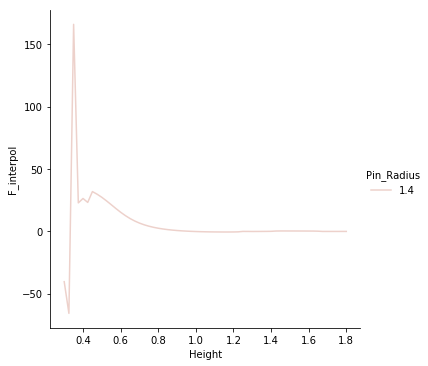

In [3]:
#compute force-distance curve for arbitrary contact angle
def get_fd(simu_df, contact_angle):
    
    df_ca = pd.DataFrame()
    for pin_radius in simu_df['Pin_Radius'].unique():
        F_fit = []
        A_fit = [] #bottom contact area
        h_range = []
        simu_df_pr = simu_df[simu_df['Pin_Radius'] == pin_radius]
        for h in simu_df_pr['Height'].unique():
            simu_df_h = simu_df_pr[simu_df_pr['Height'] == h]
            simu_df_h = simu_df_h.sort_values(by=['Contact_angle'])
            #5th order polynomial fit of Force-Contact angle data
            fh_fit = np.polyfit(simu_df_h['Contact_angle'], simu_df_h['Force_actual'], 5)
            F_fit.append(np.polyval(fh_fit,contact_angle))
            ah_fit = np.polyfit(simu_df_h['Contact_angle'], simu_df_h['Bottom_Area_corrected'], 5)
            A_fit.append(np.polyval(ah_fit,contact_angle))
            h_range.append(h)
        df_ca_temp = pd.DataFrame({'Height': h_range,
                                   'F_interpol': F_fit,
                                   'A_interpol': A_fit})
        df_ca_temp['Pin_Radius'] = pin_radius
        df_ca = df_ca.append(df_ca_temp)
    
    return df_ca

df = get_fd(simu_df, 150)
sns.relplot(data=df[df['Pin_Radius']==1.4],
            x = "Height",
            y = "F_interpol",
            hue = "Pin_Radius",
            kind = 'line')
plt.show()

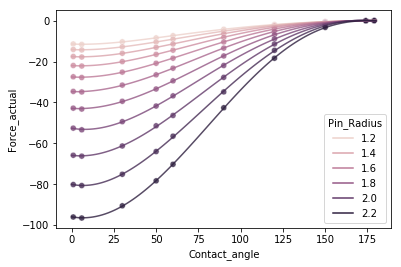

In [4]:
#get adhesion data and fit

group_vars = ['Contact_angle', 'Pin_Radius', 'Elastic_Modulus', 'Aspect_Ratio',
              'Ambient_Pressure']
simu_adh_df = simu_df.loc[simu_df.groupby(group_vars)["Force_actual"].idxmin()]

contact_angle_range = np.linspace(0,180,100)
df_fit = pd.DataFrame()
fit_dict = {} #Fit equation dictionary. pin_radius: [force-fit, height-fit] equations

for pin_radius in simu_adh_df['Pin_Radius'].unique():
    df_temp = simu_adh_df[simu_adh_df['Pin_Radius'] == pin_radius]
    #5th order polynomial fit of Force-Contact angle data
    fr_fit = np.polyfit(df_temp['Contact_angle'], df_temp['Force_actual'], 5)  
    fh_fit = np.polyfit(df_temp['Contact_angle'], df_temp['Height'], 5)  
    force_fit = np.polyval(fr_fit,contact_angle_range)
    height_fit = np.polyval(fh_fit,contact_angle_range)
    df_fit_temp = pd.DataFrame({'Contact_angle': contact_angle_range,
                                'Force_fit': force_fit,
                                'Height_fit': height_fit})
    df_fit_temp['Pin_Radius'] = pin_radius
    df_fit = df_fit.append(df_fit_temp)
    fit_dict[pin_radius] = [fr_fit, fh_fit]

fig, ax = plt.subplots()
sns.scatterplot(data=simu_adh_df,
            x = "Contact_angle",
            y = "Force_actual",
            hue = 'Pin_Radius',
            alpha = 0.8,
            ax = ax, 
            legend = False)

sns.lineplot(data=df_fit,
            x = "Contact_angle",
            y = "Force_fit",
            hue = 'Pin_Radius',
            alpha = 0.8,
            ax = ax)

plt.show()

In [5]:
#capillary bridge model: force-distance curves

def get_fd_array(Dp_Dh, alpha, asp_ratio, y_fa, y_fw, y_wa, 
                 theta_fa, theta_wa, phi_f, phi_b, s_f):
    cos_fw = (y_fa*np.cos(theta_fa*np.pi/180)-y_wa*np.cos(theta_wa*np.pi/180))/y_fw
    cos_fw = -1 if cos_fw <-1 else cos_fw
    cos_fw = 1 if cos_fw >1 else cos_fw
    theta_fw = np.arccos(cos_fw)*180/np.pi 


    N = alpha*(Dp_Dh**2)
#     print(theta_fw, N)
    s_b = (phi_f/phi_b)*Dp_Dh*s_f #bubble size scale Vb = 4/3*pi*s_b^3
    
    #in air
    df_a = get_fd(simu_df, theta_fa)
    df_a = df_a[df_a['Pin_Radius']==phi_f]
    df_a['Force'] = df_a['F_interpol']*y_fa*s_f*N
    df_a['Height_actual'] = df_a['Height']*s_f
    
    #underwater
    df_w = get_fd(simu_df, theta_fw)
    df_w = df_w[df_w['Pin_Radius']==phi_f]
    df_w['Force'] = df_w['F_interpol']*y_fw*s_f*N
    df_w['Height_actual'] = df_w['Height']*s_f
    
    #bubble's contribution
    df_b = get_fd(simu_df, 180-theta_wa)
    df_b = df_b[df_b['Pin_Radius']==phi_b]
    df_b['Force'] = df_b['F_interpol']*y_wa*s_b
    df_b['Height_actual'] = df_b['Height']*s_b
    df_b['Area_actual'] = df_b['A_interpol']*s_b*s_b
    
    h_bubble = df_a['Height_actual'] + (2*phi_f*s_f*asp_ratio)
    h_bubble_range = [min(h_bubble), max(h_bubble)]
#     print(h_bubble_range)
    bubble_actual = df_b[(df_b['Height_actual'] >= h_bubble_range[0]) & 
                        (df_b['Height_actual'] <= h_bubble_range[1])].iloc[0]
    force_bubble = bubble_actual['Force']
    area_bubble = bubble_actual['Area_actual']
    area_pad = np.pi*0.25*(Dp_Dh*2*phi_f*s_f)**2
    #area fraction to get hairs inside and outside the bubble
    area_fraction_inside = area_bubble/area_pad if area_bubble < area_pad else 1
    
    df_all = pd.merge(df_a, df_w, how='left', on='Height_actual',
                        suffixes = ['_air', '_water'])
    df_all['Force_with_bubble'] = area_fraction_inside*df_all['Force_air'] + \
                                    (1-area_fraction_inside)*df_all['Force_water'] + force_bubble
    df_all['Force_bubble_only'] = force_bubble
    df_all['Area_fraction_inside'] = area_fraction_inside

    return df_all

In [61]:
#get adhesion force of array

def get_adhesion_array(Dp_Dh, alpha, asp_ratio, y_fa, y_fw, y_wa,
                 theta_fa, theta_wa, phi_f, phi_b, s_f):
    cos_fw = (y_fa*np.cos(theta_fa*np.pi/180)-y_wa*np.cos(theta_wa*np.pi/180))/y_fw
    cos_fw = -1 if cos_fw <-1 else cos_fw
    cos_fw = 1 if cos_fw >1 else cos_fw
    theta_fw = np.arccos(cos_fw)*180/np.pi 
    print('theta_fw:', theta_fw)
    N = alpha*(Dp_Dh**2)
    s_b = (phi_f/phi_b)*Dp_Dh*s_f #bubble size scale Vb = 4/3*pi*s_b^3
    
    f_fit_eq = fit_dict[phi_f][0]  
    h_fit_eq = fit_dict[phi_f][1]   
    
    F_air = np.polyval(f_fit_eq,theta_fa)*y_fa*s_f*N
    F_water = np.polyval(f_fit_eq,theta_fw)*y_fw*s_f*N
    
    #bubble's contribution
    df_b = get_fd_array(Dp_Dh, alpha, asp_ratio, y_fa, y_fw, y_wa,
                        theta_fa, theta_wa, phi_f, phi_b, s_f)
    F_with_bubble = min(df_b['Force_with_bubble'])
    force_bubble = min(df_b['Force_bubble_only'])
#     df_b = get_fd(simu_df, 180-theta_wa)
#     df_b = df_b[df_b['Pin_Radius']==phi_b]
#     df_b['Force'] = df_b['F_interpol']*y_wa*s_b
#     df_b['Height_actual'] = df_b['Height']*s_b
#     df_b['Area_actual'] = df_b['A_interpol']*s_b*s_b
    
#     h_bubble = np.polyval(h_fit_eq,theta_fa) + (2*phi_f*s_f*asp_ratio)
#     h_id = df_b['Height_actual'].sub(h_bubble).abs().lt(1).idxmax()
#     bubble_actual = df_b.loc[h_id]
#     print(bubble_actual)
#     force_bubble = bubble_actual['Force']
#     area_bubble = bubble_actual['Area_actual']
#     area_pad = np.pi*0.25*(Dp_Dh*2*phi_f*s_f)**2
#     #area fraction to get hairs inside and outside the bubble
#     area_fraction_inside = area_bubble/area_pad if area_bubble < area_pad else 1
    
#     F_with_bubble = area_fraction_inside*F_air + \
#                         (1-area_fraction_inside)*F_water + force_bubble
    return F_air, F_water, F_with_bubble, force_bubble



In [7]:
#ladybug's parameter values
N_h = 500 #number of hairs
D_h = 4e-6 #hair diameter (m)
D_p = 200e-6 #pad diameter (m)
L_h = 40e-6 #hair length (m)
y_fa = 27e-3 #fluid-air interfacial tension (N/m) https://pubs.acs.org/doi/10.1021/la960800g
y_fw = 55e-3 #fluid-water interfacial tension (N/m)
y_wa = 72e-3 #water surface tension (N/m)
V_f = 4e-18 #fluid volume (m^3)
V_b = 1e-12 #bubble volume (m^3)

#convert to model parameters
s_f = (3*V_f/(4*np.pi))**(1/3) #s_f
s_b = (3*V_b/(4*np.pi))**(1/3) #s_b
phi_f = round(D_h/(2*s_f),1) #D_h/2s_f
phi_b = round(D_p/(2*s_b),1) #D_p/2s_b
Dp_Dh = D_p/D_h
alpha = N_h/(Dp_Dh**2)
asp_ratio = L_h/D_h
print('Dp_Dh:', Dp_Dh, 'alpha:', alpha, 'asp_ratio:', asp_ratio, 
      'y_fa:', y_fa, 'y_fw:', y_fw, 'y_wa:', y_wa,
      'phi_f', phi_f, 'phi_b', phi_b, 's_f', s_f)

Dp_Dh: 50.00000000000001 alpha: 0.19999999999999993 asp_ratio: 10.000000000000002 y_fa: 0.027 y_fw: 0.055 y_wa: 0.072 phi_f 2.0 phi_b 1.6 s_f 9.847450218426974e-07


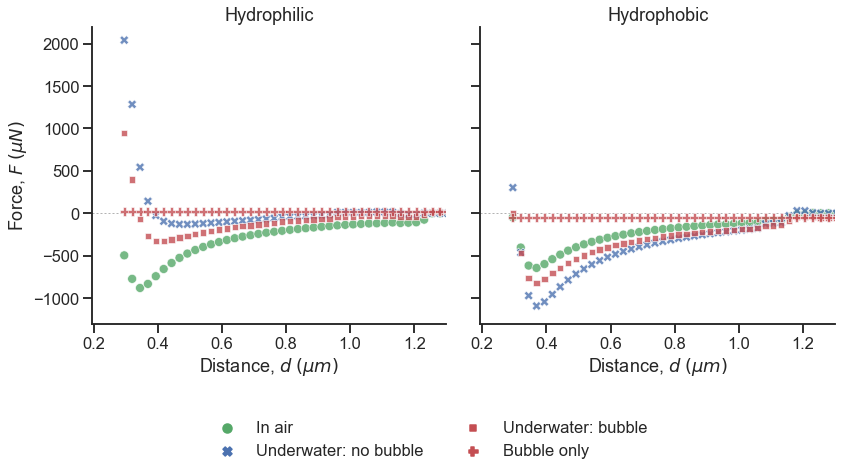

In [8]:
#Get model data 

# Dp_Dh = 50 #Dp/Dh
# alpha = 0.1
# asp_ratio = 10 #L/Dh

# y_fa = 1 #fluid-air interfacial tension (N/m) https://pubs.acs.org/doi/10.1021/la960800g
# y_fw = 2 #fluid-water interfacial tension (N/m)
# y_wa = 3 #water surface tension (N/m)
# phi_f = 2 #fluid size parameter
# phi_b = 1.6 #bubble size parameter

# s_f = 1 #fluid size scale Vf = 4/3*pi*s_f^3

#hydrophilic
theta_fa = 6 #fluid-substrate contact angle in air
theta_wa = 20 #water-substrate contact angle in air
df_phil = get_fd_array(Dp_Dh, alpha, asp_ratio, y_fa, y_fw, y_wa,
                       theta_fa, theta_wa, phi_f, phi_b, s_f)
df_phil['Substrate'] = 'Hydrophilic'
df_phil['theta_fa'] = theta_fa
df_phil['theta_wa'] = theta_wa

#hydrophobic
theta_fa = 56 #fluid-substrate contact angle in air
theta_wa = 93 #water-substrate contact angle in air
df_phob = get_fd_array(Dp_Dh, alpha, asp_ratio, y_fa, y_fw, y_wa,
                       theta_fa, theta_wa, phi_f, phi_b, s_f)
df_phob['Substrate'] = 'Hydrophobic'
df_phob['theta_fa'] = theta_fa
df_phob['theta_wa'] = theta_wa

modelData = df_phil.append(df_phob)

# Clean data
modelData.rename(columns = {'Force_air': 'In air',
                            'Force_with_bubble': 'Underwater: bubble',
                            'Force_water': 'Underwater: no bubble',
                            'Force_bubble_only': 'Bubble only',
                            'Height_actual': 'Distance'},
                 inplace = True)
column_list = list(modelData.columns)

#forces to include in plot (used to convert data to long form)
force_order = ['In air','Underwater: no bubble','Underwater: bubble', 'Bubble only']


#reshape force data into long form based on force_vars
id_vars_list = [x for x in column_list if x not in force_order]
data_reshaped = pd.melt(modelData,
                        id_vars = id_vars_list,
                        var_name="Model",
                        value_name="Force")


data_reshaped['Force'] = data_reshaped['Force']/1e-6 #uN
data_reshaped['Distance'] = data_reshaped['Distance']/1e-6 #um

# Configure plot style
sns.set_theme(context = 'talk',
              style="ticks")
fig_size = (12,6) #figure size

# Plot data
color_list = ['g', 'b', 'r', 'r'] #corresponding colors
line_styles = [(1, 0), (1, 0), (1, 0), (1, 1)] #set True if line style needs to be changed by default. or include style as list of tuples {on, off) eg. (1,0): solid, (1,1):dotted

# Draw a nested boxplot to show bills by day and time
ax = sns.relplot(data=data_reshaped,
                 x = "Distance",
                 y = "Force",
                 hue = "Model",
                 hue_order = force_order,
                 style = "Model",
                 style_order = force_order,
                 col = 'Substrate',
                 col_order = ['Hydrophilic', 'Hydrophobic'],
                 palette= color_list,
                 kind = 'scatter',
                 alpha = 0.8,
                 facet_kws={"legend_out": True})

(ax.map(plt.axhline, y=0, color=".7", dashes=(2, 2), zorder=0, linewidth=1)
     .set_axis_labels("Distance, $d$ $(\mu m)$", r"Force, $F$ $(\mu N)$")
  .tight_layout(w_pad=0))

fig = ax.fig

#use scientific notation
# for ax1 in ax.axes.flatten():
#     ax1.ticklabel_format(style='sci', scilimits=(0,0), axis='y')
    
#legend adjust
handles, labels = ax.axes[0][0].get_legend_handles_labels()
leg = ax._legend

leg.remove()
fig.tight_layout()

leg = plt.legend(handles, labels, ncol = 2,
                 framealpha = 0)
        
leg_bbox = leg.get_tightbbox(fig.canvas.get_renderer())
x0, y0, w, h = leg_bbox.inverse_transformed(fig.transFigure).bounds
bbox = (-w, -h, 1 + 2 * w, 1 +  2 * h)
leg.set_bbox_to_anchor(bbox, transform = fig.transFigure)
leg._loc = 8 #legend location

#format plot
ax.fig.set_size_inches(*fig_size)

#replace titles in order left to right
titles = ['Hydrophilic', 'Hydrophobic']
axes = ax.axes.flatten()
for i, ax1 in enumerate(axes):
    ax1.set_title(titles[i])
    ax1.set_xlim(right=1.3)
#     ax1.set_ylim(top=1000)
# plt.autoscale(enable=True, axis='both')    
plt.show()



In [126]:
#save plot
plot_name = "Figure5-Model_effect_of_substrate"
timestamp = datetime.today().strftime('%Y%m%d%H%M%S')
fig = ax.fig
fig.savefig(plot_name + "-" + timestamp + ".svg",
            bbox_inches='tight', transparent = True)

In [9]:
#ladybug's parameter values
N_h = 500 #number of hairs
D_h = 4e-6 #hair diameter (m)
D_p = 200e-6 #pad diameter (m)
L_h = 40e-6 #hair length (m)
y_fa = 27e-3 #fluid-air interfacial tension (N/m) https://pubs.acs.org/doi/10.1021/la960800g
y_fw = 55e-3 #fluid-water interfacial tension (N/m)
y_wa = 72e-3 #water surface tension (N/m)
V_f = 4e-18 #fluid volume (m^3)
V_b = 1e-12 #bubble volume (m^3)

#convert to model parameters
s_f = (3*V_f/(4*np.pi))**(1/3) #s_f
s_b = (3*V_b/(4*np.pi))**(1/3) #s_b
phi_f = round(D_h/(2*s_f),1) #D_h/2s_f
phi_b = round(D_p/(2*s_b),1) #D_p/2s_b
Dp_Dh = D_p/D_h
alpha = N_h/(Dp_Dh**2)#contact area fraction kept fixed
# asp_ratio = L_h/D_h
print('alpha:', alpha, 'asp_ratio:', asp_ratio, 
      'y_fa:', y_fa, 'y_fw:', y_fw, 'y_wa:', y_wa,
      'phi_f', phi_f, 'phi_b', phi_b)


alpha: 0.19999999999999993 asp_ratio: 10.000000000000002 y_fa: 0.027 y_fw: 0.055 y_wa: 0.072 phi_f 2.0 phi_b 1.6


contact area: 6283.185307179586 um^2
expt avg. contact area in air: 7724.5 um^2


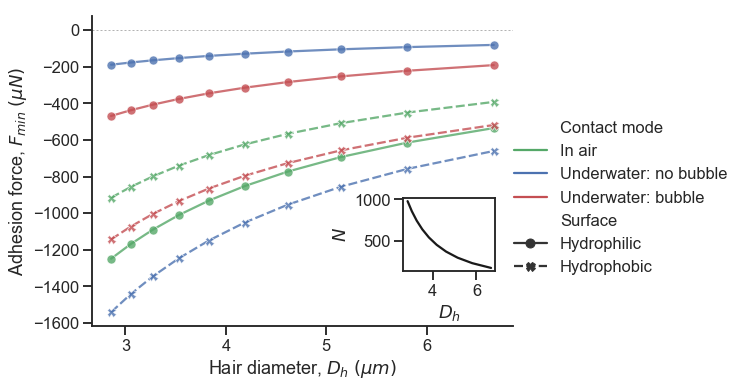

In [10]:
#Effect of hair diameter (self-similar scaling)

#Get model data

# alpha = 0.1
# asp_ratio = 10 #L/Dh

# y_fa = 1 #fluid-air interfacial tension (N/m) https://pubs.acs.org/doi/10.1021/la960800g
# y_fw = 2 #fluid-water interfacial tension (N/m)
# y_wa = 3 #water surface tension (N/m)
# phi_f = 2 #fluid size parameter
# phi_b = 1.6 #bubble size parameter

# s_f = 1 #fluid size scale Vf = 4/3*pi*s_f^3

Dp_Dh_array = np.linspace(30,70,10)
# Dp = 200

modelData = pd.DataFrame()
hairnumData = pd.DataFrame()

for Dp_Dh in Dp_Dh_array:
    Dh = D_p/Dp_Dh 
    s_f = Dh/(2*phi_f) #fluid size scale Vf = 4/3*pi*s_f^3
    asp_ratio = L_h/Dh
    #Hydrophilic
    theta_fa = 6 #fluid-substrate contact angle in air
    theta_wa = 20 #water-substrate contact angle in air
    Fa, Fw, Fb, Fbo = get_adhesion_array(Dp_Dh, alpha, asp_ratio, y_fa, y_fw, y_wa,
                                  theta_fa, theta_wa, phi_f, phi_b, s_f)
    df_phil = pd.DataFrame({'Force_air': [Fa],
                            'Force_with_bubble': [Fb],
                            'Force_water': [Fw],
                            'Force_bubble_only': [Fbo],
                            'Hair_dia': [Dh]})
    df_phil['Surface'] = 'Hydrophilic'
    df_phil['theta_fa'] = theta_fa
    df_phil['theta_wa'] = theta_wa
    
    #Hydrophobic
    theta_fa = 56 #fluid-substrate contact angle in air
    theta_wa = 93 #water-substrate contact angle in air
    Fa, Fw, Fb, Fbo = get_adhesion_array(Dp_Dh, alpha, asp_ratio, y_fa, y_fw, y_wa,
                                  theta_fa, theta_wa, phi_f, phi_b, s_f)
    df_phob = pd.DataFrame({'Force_air': [Fa],
                            'Force_with_bubble': [Fb],
                            'Force_water': [Fw],
                            'Force_bubble_only': [Fbo],
                            'Hair_dia': [Dh]})
    df_phob['Surface'] = 'Hydrophobic'
    df_phob['theta_fa'] = theta_fa
    df_phob['theta_wa'] = theta_wa
    
    df_all = df_phil.append(df_phob)
    
    modelData = modelData.append(df_all)
    
    #number of hairs
    N = alpha*(Dp_Dh**2)
    hairnum_temp = pd.DataFrame({'Hair_dia': [Dh],
                                'Number_of_hairs': [N]})
    hairnumData = hairnumData.append(hairnum_temp)
    
print('contact area:', N*0.25*np.pi*Dh*Dh*1e12, 'um^2')
print('expt avg. contact area in air:', 7724.5, 'um^2')

# Data clean
modelData.rename(columns = {'Force_air': 'In air',
                            'Force_with_bubble': 'Underwater: bubble',
                            'Force_water': 'Underwater: no bubble',
                            'Force_bubble_only': 'Bubble only'},
                 inplace = True)

#forces to include in plot (used to convert data to long form)
force_order = ['In air','Underwater: no bubble','Underwater: bubble']#, 'Bubble only']


column_list = list(modelData.columns)
#reshape force data into long form based on force_order
id_vars_list = [x for x in column_list if x not in force_order]
data_reshaped = pd.melt(modelData,
                        id_vars = id_vars_list,
                        var_name="Contact mode",
                        value_name="Force")


data_reshaped['Force'] = data_reshaped['Force']/1e-6 #uN
data_reshaped['Hair_dia'] = data_reshaped['Hair_dia']/1e-6 #um
hairnumData['Hair_dia'] = hairnumData['Hair_dia']/1e-6 #um

# Configure plot style
sns.set_theme(context = 'talk',
              style="ticks")
fig_size = (7.5,6) #figure size

# Plot data
color_list = ['g', 'b', 'r']#, 'r'] #corresponding colors
line_styles = [(1, 0), (1, 0), (1, 0), (1, 1)] #set True if line style needs to be changed by default. or include style as list of tuples {on, off) eg. (1,0): solid, (1,1):dotted

# Draw a nested boxplot to show bills by day and time
ax = sns.relplot(data=data_reshaped,
                 x = "Hair_dia",
                 y = "Force",
                 hue = "Contact mode",
                 hue_order = force_order,
                 style = "Surface",
                 style_order = ['Hydrophilic','Hydrophobic'],
                 palette= color_list,
                 kind = 'line',
                 markers = True,
                 #dashes = line_styles,
                 alpha = 0.8,
                 facet_kws={"legend_out": True})

(ax.map(plt.axhline, y=0, color=".7", dashes=(2, 2), zorder=0, linewidth=1)
     .set_axis_labels(r'Hair diameter, $D_h$ $(\mu m)$', 
                      r"Adhesion force, $F_{min}$ $(\mu N)$")
  .tight_layout(w_pad=0))

fig = ax.fig

#use scientific notation
# for ax1 in ax.axes.flatten():
#     ax1.ticklabel_format(style='sci', scilimits=(0,0), axis='both')
    
#legend adjust
col_num = 1 #number of legend columns SET
handles, labels = ax.axes[0][0].get_legend_handles_labels()
leg = ax._legend

leg.remove()
fig.tight_layout()

leg = plt.legend(handles, labels, ncol = col_num,
                 framealpha = 0)

        
leg_bbox = leg.get_tightbbox(fig.canvas.get_renderer())
x0, y0, w, h = leg_bbox.inverse_transformed(fig.transFigure).bounds

bbox = (-w, -h, 1 + 2 * w, 1 +  2 * h)
leg.set_bbox_to_anchor(bbox, transform = fig.transFigure)
leg._loc = 7 #legend location SET


#inset plot: Number of hairs
l, b, h, w = .75, .33, .17, .17
ax2 = fig.add_axes([l, b, w, h])
ax2.plot(hairnumData['Hair_dia'], hairnumData['Number_of_hairs'], 'k')
ax2.set_xlabel(r'$D_h$', fontsize='medium')
ax2.set_ylabel(r"$N$", fontsize='medium')


#format plot
ax.fig.set_size_inches(*fig_size)


plt.show()

In [129]:
#save plot
plot_name = "Figure6-Model_effect_of_hair_size"
timestamp = datetime.today().strftime('%Y%m%d%H%M%S')
fig = ax.fig
fig.savefig(plot_name + "-" + timestamp + ".svg",
            bbox_inches='tight', transparent = True)

In [11]:
#ladybug's parameter values
N_h = 500 #number of hairs
D_h = 4e-6 #hair diameter (m)
D_p = 200e-6 #pad diameter (m)
L_h = 40e-6 #hair length (m)
y_fa = 27e-3 #fluid-air interfacial tension (N/m) https://pubs.acs.org/doi/10.1021/la960800g
y_fw = 55e-3 #fluid-water interfacial tension (N/m)
y_wa = 72e-3 #water surface tension (N/m)
V_f = 4e-18 #fluid volume (m^3)
# V_b = 1e-12 #bubble volume (m^3)

#convert to model parameters
s_f = (3*V_f/(4*np.pi))**(1/3) #s_f
# s_b = (3*V_b/(4*np.pi))**(1/3) #s_b
phi_f = round(D_h/(2*s_f),1) #D_h/2s_f
# phi_b = round(D_p/(2*s_b),1) #D_p/2s_b
Dp_Dh = D_p/D_h
alpha = N_h/(Dp_Dh**2)
asp_ratio = L_h/D_h
print('Dp_Dh:', Dp_Dh, 'alpha:', alpha, 'asp_ratio:', asp_ratio, 
      'y_fa:', y_fa, 'y_fw:', y_fw, 'y_wa:', y_wa,
      'phi_f', phi_f, 's_f', s_f)

Dp_Dh: 50.00000000000001 alpha: 0.19999999999999993 asp_ratio: 10.000000000000002 y_fa: 0.027 y_fw: 0.055 y_wa: 0.072 phi_f 2.0 s_f 9.847450218426974e-07


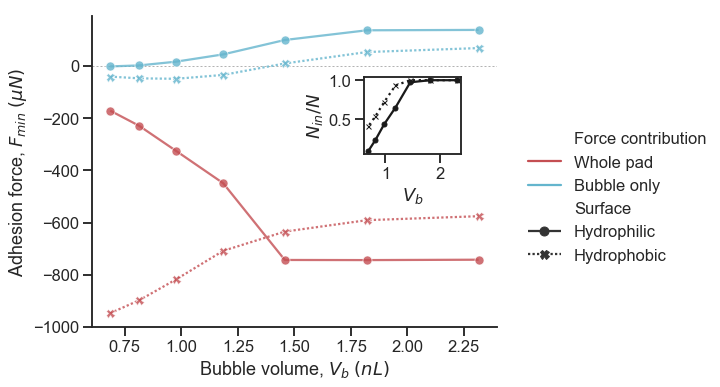

In [12]:
#Effect of bubble volume

# Get model data

# Dp_Dh = 50 #Dp/Dh
# alpha = 0.1
# asp_ratio = 10 #L/Dh

# y_fa = 1 #fluid-air interfacial tension (N/m) https://pubs.acs.org/doi/10.1021/la960800g
# y_fw = 2 #fluid-water interfacial tension (N/m)
# y_wa = 3 #water surface tension (N/m)
# phi_f = 2 #fluid size parameter

# s_f = 1 #fluid size scale Vf = 4/3*pi*s_f^3

#hydrophilic
theta_fa = 6 #fluid-substrate contact angle in air
theta_wa = 20 #water-substrate contact angle in air

df_phil = pd.DataFrame()
F_bubble = []
F_bubble_only = []
volume_bubble = []
phi_b_list = [1.2,1.3,1.4,1.5,1.6,1.7,1.8] 
for phi_b in phi_b_list:
    df_all = get_fd_array(Dp_Dh, alpha, asp_ratio, y_fa, y_fw, y_wa,
                          theta_fa, theta_wa, phi_f, phi_b, s_f)
    s_b = (phi_f/phi_b)*Dp_Dh*s_f
    df_temp = pd.DataFrame({'F_bubble': [min(df_all['Force_with_bubble'])],
                           'F_bubble_only': [min(df_all['Force_bubble_only'])],
                           'volume_bubble': [(4/3)*np.pi*(s_b**3)],
                           'phi_b':phi_b,
                           'Area_fraction_inside': [min(df_all['Area_fraction_inside'])]})
    df_phil = df_phil.append(df_temp)

df_phil['Surface'] = 'Hydrophilic'
df_phil['theta_fa'] = theta_fa
df_phil['theta_wa'] = theta_wa

#hydrophobic
theta_fa = 56 #fluid-substrate contact angle in air
theta_wa = 93 #water-substrate contact angle in air

df_phob = pd.DataFrame()
F_bubble = []
F_bubble_only = []
volume_bubble = []
phi_b_list = [1.2,1.3,1.4,1.5,1.6,1.7,1.8] 
for phi_b in phi_b_list:
    df_all = get_fd_array(Dp_Dh, alpha, asp_ratio, y_fa, y_fw, y_wa,
                          theta_fa, theta_wa, phi_f, phi_b, s_f)
    s_b = (phi_f/phi_b)*Dp_Dh*s_f
    df_temp = pd.DataFrame({'F_bubble': [min(df_all['Force_with_bubble'])],
                           'F_bubble_only': [min(df_all['Force_bubble_only'])],
                           'volume_bubble': [(4/3)*np.pi*(s_b**3)],
                           'phi_b':phi_b,
                           'Area_fraction_inside': [min(df_all['Area_fraction_inside'])]})
    df_phob = df_phob.append(df_temp)

df_phob['Surface'] = 'Hydrophobic'
df_phob['theta_fa'] = theta_fa
df_phob['theta_wa'] = theta_wa

modelData = df_phil.append(df_phob)

# Data clean
modelData.rename(columns = {'F_bubble': 'Whole pad',
                            'F_bubble_only': 'Bubble only'},
                 inplace = True)

#forces to include in plot (used to convert data to long form)
force_order = ['Whole pad', 'Bubble only']


column_list = list(modelData.columns)
#reshape force data into long form based on force_order
id_vars_list = [x for x in column_list if x not in force_order]
data_reshaped = pd.melt(modelData,
                        id_vars = id_vars_list,
                        var_name="Force contribution",
                        value_name="Force")


data_reshaped['Force'] = data_reshaped['Force']/1e-6 #uN
data_reshaped['volume_bubble'] = data_reshaped['volume_bubble']/1e-12 #nL
df_phil['volume_bubble'] = df_phil['volume_bubble']/1e-12 #nL
df_phob['volume_bubble'] = df_phob['volume_bubble']/1e-12 #nL

# Configure plot style
sns.set_theme(context = 'talk',
              style="ticks")
fig_size = (7.5,6) #figure size

# Plot data
color_list = ['r', 'c'] #corresponding colors
line_styles = [(1, 0),(1, 1)] #set True if line style needs to be changed by default. or include style as list of tuples {on, off) eg. (1,0): solid, (1,1):dotted

# Draw a nested boxplot to show bills by day and time
ax = sns.relplot(data=data_reshaped,
                 x = "volume_bubble",
                 y = "Force",
                 hue = "Force contribution",
                 hue_order = force_order,
                 style = "Surface",
                 style_order = ['Hydrophilic','Hydrophobic'],
                 palette= color_list,
                 kind = 'line',
                 markers = True,
                 dashes = line_styles,
                 alpha = 0.8,
                 facet_kws={"legend_out": True})

(ax.map(plt.axhline, y=0, color=".7", dashes=(2, 2), zorder=0, linewidth=1)
     .set_axis_labels(r'Bubble volume, $V_b$ $(nL)$', 
                      r"Adhesion force, $F_{min}$ $(\mu N)$")
  .tight_layout(w_pad=0))

fig = ax.fig

#use scientific notation
# for ax1 in ax.axes.flatten():
#     ax1.ticklabel_format(style='sci', scilimits=(0,0), axis='both')
    
#legend adjust
col_num = 1 #number of legend columns SET
handles, labels = ax.axes[0][0].get_legend_handles_labels()
leg = ax._legend

leg.remove()
fig.tight_layout()

leg = plt.legend(handles, labels, ncol = col_num,
                 framealpha = 0)

        
leg_bbox = leg.get_tightbbox(fig.canvas.get_renderer())
x0, y0, w, h = leg_bbox.inverse_transformed(fig.transFigure).bounds

bbox = (-w, -h, 1 + 2 * w, 1 +  2 * h)
leg.set_bbox_to_anchor(bbox, transform = fig.transFigure)
leg._loc = 7 #legend location SET

#inset plot: Fraction of hairs inside bubble
l, b, h, w = .7, .6, .18, .18
ax2 = fig.add_axes([l, b, w, h])
ax2.plot(df_phil['volume_bubble'], df_phil['Area_fraction_inside'], '-ok', markersize=5)
ax2.plot(df_phob['volume_bubble'], df_phob['Area_fraction_inside'], ':xk', markersize=5)
ax2.set_xlabel(r'$V_b$', fontsize='medium')
ax2.set_ylabel(r"$N_{in}/N$", fontsize='medium')
# ax2.ticklabel_format(style='sci', scilimits=(0,0), axis='x')

#format plot
ax.fig.set_size_inches(*fig_size)


plt.show()

In [132]:
#save plot
plot_name = "Figure7-Model_effect_of_bubble_volume"
timestamp = datetime.today().strftime('%Y%m%d%H%M%S')
fig = ax.fig
fig.savefig(plot_name + "-" + timestamp + ".svg",
            bbox_inches='tight', transparent = True)

In [62]:
#ladybug's case
N_h = 500 #number of hairs
D_h = 4e-6 #hair diameter (m)
D_p = 200e-6 #pad diameter (m)
L_h = 40e-6 #hair length (m)
y_fa = 27e-3 #fluid-air interfacial tension (N/m) https://pubs.acs.org/doi/10.1021/la960800g
y_fw = 55e-3 #fluid-water interfacial tension (N/m)
y_wa = 72e-3 #water surface tension (N/m)
V_f = 4e-18 #fluid volume (m^3)
V_b = 1e-12 #bubble volume (m^3)


s_f = (3*V_f/(4*np.pi))**(1/3) #s_f
s_b = (3*V_b/(4*np.pi))**(1/3) #s_b
phi_f = round(D_h/(2*s_f),1) #D_h/2s_f
phi_b = round(D_p/(2*s_b),1) #D_p/2s_b
Dp_Dh = D_p/D_h
alpha = N_h/(Dp_Dh**2)
asp_ratio = L_h/D_h

print('Dp_Dh:', Dp_Dh, 'alpha:', alpha, 'asp_ratio:', asp_ratio, 
      'y_fa:', y_fa, 'y_fw:', y_fw, 'y_wa:', y_wa,
      'phi_f', phi_f, 's_f', s_f, 'phi_b', phi_b, 's_b', s_b)

insect_modelData = pd.DataFrame()

#hydrophilic
theta_fa = 6 #fluid-substrate contact angle in air
theta_wa = 20 #water-substrate contact angle in air

F_phil_a, F_phil_w, Fb, Fbo = get_adhesion_array(Dp_Dh, alpha, asp_ratio, y_fa, y_fw, y_wa,
                                                 theta_fa, theta_wa, phi_f, phi_b, s_f)
# cos_fw = (y_fa*np.cos(theta_fa*np.pi/180)-y_wa*np.cos(theta_wa*np.pi/180))/y_fw
# cos_fw = -1 if cos_fw <-1 else cos_fw
# cos_fw = 1 if cos_fw >1 else cos_fw
# theta_fw = np.arccos(cos_fw)*180/np.pi 
# print(theta_fw)

# fr_fit = fit_dict[phi_f][0]
# F_phil_a = np.polyval(fr_fit,theta_fa)*y_fa*s_f*N_h
# F_phil_w = np.polyval(fr_fit,theta_fw)*y_fw*s_f*N_h
df_temp = pd.DataFrame({'Contact_type': ['In air',
                                         'Underwater: no bubble',
                                         'Underwater: bubble',
                                         'Bubble only'],
                        'Adhesion_Force': [F_phil_a, F_phil_w, Fb, Fbo]})
df_temp['Substrate'] = 'Hydrophilic'
insect_modelData = insect_modelData.append(df_temp)
print('Hydrophilic:', F_phil_a/1e-6, F_phil_w/1e-6, Fb/1e-6, Fbo/1e-6)

#hydrophobic
theta_fa = 56 #fluid-substrate contact angle in air
theta_wa = 93 #water-substrate contact angle in air

F_phob_a, F_phob_w, Fb, Fbo = get_adhesion_array(Dp_Dh, alpha, asp_ratio, y_fa, y_fw, y_wa,
                                                 theta_fa, theta_wa, phi_f, phi_b, s_f)

df_temp = pd.DataFrame({'Contact_type': ['In air',
                                         'Underwater: no bubble',
                                         'Underwater: bubble',
                                         'Bubble only'],
                        'Adhesion_Force': [F_phob_a, F_phob_w, Fb, Fbo]})
df_temp['Substrate'] = 'Hydrophobic'
insect_modelData = insect_modelData.append(df_temp)

# cos_fw = (y_fa*np.cos(theta_fa*np.pi/180)-y_wa*np.cos(theta_wa*np.pi/180))/y_fw
# cos_fw = -1 if cos_fw <-1 else cos_fw
# cos_fw = 1 if cos_fw >1 else cos_fw
# theta_fw = np.arccos(cos_fw)*180/np.pi 
# print(theta_fw)

# fr_fit = fit_dict[phi_f][0]
# F_phob_a = np.polyval(fr_fit,theta_fa)*y_fa*s_f*N_h
# F_phob_w = np.polyval(fr_fit,theta_fw)*y_fw*s_f*N_h
print('Hydrophobic:', F_phob_a/1e-6, F_phob_w/1e-6, Fb/1e-6, Fbo/1e-6)
print(insect_modelData)

insect_modelData['Data'] = 'Model'
insect_modelData['Adhesion_Force'] *= -1e6

Dp_Dh: 50.00000000000001 alpha: 0.19999999999999993 asp_ratio: 10.000000000000002 y_fa: 0.027 y_fw: 0.055 y_wa: 0.072 phi_f 2.0 s_f 9.847450218426974e-07 phi_b 1.6 s_b 6.203504908994004e-05
theta_fw: 137.89550377387408
Hydrophilic: -878.5526906586565 -133.16619553731434 -325.2623260616374 16.434052240586663
theta_fw: 69.9386943715081
Hydrophobic: -644.0870827596619 -1084.0002406556102 -818.3003223828197 -49.1982296178922
            Contact_type  Adhesion_Force    Substrate
0                 In air       -0.000879  Hydrophilic
1  Underwater: no bubble       -0.000133  Hydrophilic
2     Underwater: bubble       -0.000325  Hydrophilic
3            Bubble only        0.000016  Hydrophilic
0                 In air       -0.000644  Hydrophobic
1  Underwater: no bubble       -0.001084  Hydrophobic
2     Underwater: bubble       -0.000818  Hydrophobic
3            Bubble only       -0.000049  Hydrophobic


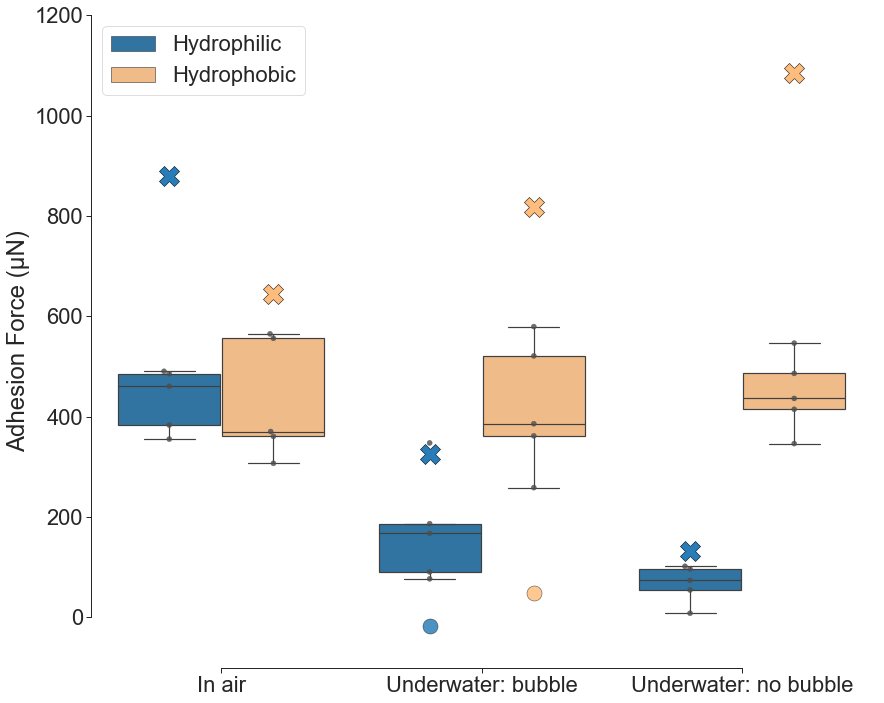

In [42]:
#Load and clean experiment data
# Load experiment data
exptData = pd.read_excel('../Data/experiment_data_all-210105210502.xlsx',
                         engine = 'openpyxl', index_col=0)
exptData = exptData[exptData['Include Data?'] == 'Yes'] #filter out unecessary data
exptData.rename(columns = {'Pulloff Force': 'Adhesion_Force'}, inplace = True)
exptData.rename(columns = {'Contact Type': 'Contact_type'}, inplace = True)
exptData = exptData[exptData["Contact_type"] != "Ambiguous"] #filter out ambiguous data
exptData.replace({'Contact_type': {'Dry': 'In air',
                                   'Bubble': 'Underwater: bubble',
                                   'Wet': 'Underwater: no bubble',
                                   'Ambiguous': 'Underwater: bad contact'}},
                 inplace = True)
exptData['Data'] = 'Experiment'
exptData_original = exptData.copy()

#average data based on experiment date
group_cols = ['Date of Experiment', 'Contact_type','Substrate','Data']
exptData = exptData.groupby(group_cols).mean().reset_index()
exptData = exptData.replace({'Substrate': {'Glass': 'Hydrophilic',
                                           'PFOTS': 'Hydrophobic'}})

#Load and clean model data
# # Model data
# #folderPath = 'E:/Work/Surface Evolver/Data/Bubble_Bridge/20201020 ladybug data final/'
# dataPath = '../Data/summary_data_ladybug.xlsx'
# modelData = pd.read_excel(dataPath, engine = 'openpyxl')
# # modelData.rename(columns = {'Model': 'Contact_type'}, inplace = True)
# modelData.rename(columns = {'Air': 'In air',
#                                    'Underwater: Bubble': 'Underwater: bubble',
#                                    'Underwater: Wet': 'Underwater: no bubble'},
#                  inplace = True)
# column_list = list(modelData.columns)
# modelData = modelData[modelData['Hair dia'] == 4e-6] #filter hair diameter (4um)
# #force variables in data (used to convert data to long form)
# force_vars = ['Force_hair_air', 'Force_hair_water', 'Force (hair)',
#               'Bubble only', 'Underwater: bubble', 'In air', 'Underwater: no bubble']
# #forces to include in plot
# force_order = ['In air','Underwater: no bubble','Underwater: bubble', 'Bubble only']
# group_param = ['Contact_type', 'Contact Angle', 'θ-fa', 'θ-fw',
#                'D_p/D_h', 'a_b', 'a_f', 'Fluid data file',
#                'Bubble data file']

# #reshape force data into long form based on force_vars
# id_vars_list = [x for x in column_list if x not in force_vars]
# data_reshaped = pd.melt(modelData,
#                         id_vars = id_vars_list,
#                         var_name="Contact_type",
#                         value_name="Adhesion_Force")

# #filter data to only include relevant forces
# data_filtered = data_reshaped[data_reshaped['Contact_type'].
#                               isin(force_order)]
# #group data (find maxima)
# data_grouped = data_filtered.groupby(group_param).min().reset_index()
# data_grouped['Adhesion_Force'] *= -1000 #mN to uN convert (+ve convention)
# #normalized adhesion calculation
# data_grouped['Normalized_Adhesion_Force'] = data_grouped['Adhesion_Force']/\
#                                             data_grouped['Hair Area']*1e-12

# data_grouped['Substrate'] = np.where(data_grouped['Contact Angle']== 24,
#                                      'Glass', 'PFOTS')

# Organize experimental and model data
exptData_relevant = exptData[['Contact_type',
                              'Adhesion_Force',
                              'Substrate',
                              'Data']].copy()
modelData_relevant = insect_modelData[['Contact_type',
                                       'Adhesion_Force',
                                       'Substrate',
                                       'Data']].copy()

modelData_bubbleonly = modelData_relevant[modelData_relevant['Contact_type']=='Bubble only']
modelData_bubbleonly = modelData_bubbleonly.replace({'Contact_type': {'Bubble only': 'Underwater: bubble'}})

modelData_rest = modelData_relevant[modelData_relevant['Contact_type']!='Bubble only']
# dataCombined = exptData_relevant.append(modelData_relevant)

# Configure plot style
sns.set(rc={'figure.figsize':(14,12)})
sns.set_theme(context = 'paper',style="ticks",
              palette="Set2", font_scale = 2.5)
color_list = [sns.color_palette('tab20')[0], sns.color_palette('tab20')[3]]
# color_list.reverse()

# Plot data
contact_order = ['In air', 'Underwater: bubble', 'Underwater: no bubble']
# rc('text', usetex=False)

widths = [1]
heights = [1,9]
# gs_kw = dict(width_ratios=widths, height_ratios=heights)
f, (ax_main) = plt.subplots(1, 1)#, sharex=True, gridspec_kw=gs_kw)
#Draw model prediction as stars (for outlier)
ax0 = sns.swarmplot(x='Contact_type', y='Adhesion_Force',
                hue='Substrate', order= contact_order, hue_order = ['Hydrophilic', 'Hydrophobic'],
                    dodge = True, marker = 'X', edgecolor = 'k',
                    linewidth=0.5, size = 20, alpha = 0.8,
                data=modelData_rest, ax = ax_main, palette = color_list)
ax0.get_legend().remove()

#Draw model prediction as stars (for main data)
ax1 = sns.swarmplot(x='Contact_type', y='Adhesion_Force',
                hue='Substrate', order= contact_order, hue_order = ['Hydrophilic', 'Hydrophobic'],
                    dodge = True, marker = 'X', edgecolor = 'k',
                    linewidth=0.5, size = 20, alpha = 0.8,
                data=modelData_rest, ax = ax_main, palette = color_list)
#define yaxis break condition
# ax_break.set_ylim(1600, 1700)  # outliers only
ax_main.set_ylim(-100, 1200)  # most of the data
legs1 = ax1.get_legend().texts

#Draw model bubble only prediction as circles
ax15 = sns.swarmplot(x='Contact_type', y='Adhesion_Force',
                hue='Substrate', order= contact_order, hue_order = ['Hydrophilic', 'Hydrophobic'],
                    dodge = True, marker = 'o', edgecolor = 'k',
                    linewidth=0.5, size = 15, alpha = 0.8,
                data=modelData_bubbleonly, ax = ax_main, palette = color_list)

#Experimental data points plot overlayed
ax20 = sns.swarmplot(x='Contact_type', y='Adhesion_Force',
                hue='Substrate', order= contact_order, hue_order = ['Hydrophilic', 'Hydrophobic'],
                    dodge = True, marker = 'o', edgecolor = '0.3',
                    linewidth=0.5, size = 5, alpha = 0.8,
                data=exptData_relevant, ax = ax_main, palette = ['0.3', '0.3'])
ax20.get_legend().remove()

#Experimental data box plot overlayed
ax2 = sns.boxplot(x='Contact_type', y='Adhesion_Force',
                hue='Substrate', order = contact_order, hue_order = ['Hydrophilic', 'Hydrophobic'],
                data=exptData_relevant, ax = ax_main, palette = color_list, fliersize=0)

#clean up legend
handles, labels = ax2.get_legend_handles_labels()
ax2.get_legend().remove()
ax_main.legend(handles[0:2], labels[0:2])
ax_main.set_xlabel(None)
ax_main.set_ylabel('Adhesion Force (μN)')#, position = (0,0.65))
# ax2.set(xlabel='Contact Type', ylabel='Adhesion Force $[μN]$')

sns.despine(offset=0, trim=True)
# # hide the spines between ax and ax2
# ax_break.set_xlabel(None)
# ax_break.set_ylabel(None)
# ax_break.spines['bottom'].set_visible(False)
# ax_break.spines['top'].set_visible(False)
# ax_main.spines['top'].set_visible(False)
# ax_break.xaxis.set_tick_params(length=0)

# #create dashes at axis break
# d = .02  # how big to make the diagonal lines in axes coordinates
# kwargs = dict(transform=ax_break.transAxes, color='k', clip_on=False)
# ax_break.plot((0, d), (0, 9*d), **kwargs)        # top-left diagonal

# y = 0.955
# kwargs.update(transform=ax_main.transAxes)  # switch to the bottom axes
# ax_main.plot((0, +d), (y, y + d), **kwargs)  # bottom-left diagonal

plt.show()

In [135]:
plot_name = 'Figure2-Expt_effect_of_contact'

timestamp = datetime.today().strftime('%Y%m%d%H%M%S')
fig = ax2.get_figure()
fig.savefig(plot_name + "-" + timestamp + ".svg",
            bbox_inches = 'tight', transparent = True)

Linear mixed effect model

In [43]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
# model = sm.MixedLM(endog, exog, groups)
# result = model.fit()
exptData_filtered = exptData_original[exptData_original["Contact_type"] != "Underwater: bad contact"]
exptData_filtered.rename(columns = {'Date of Experiment': 'Date_of_Experiment'}, inplace = True)
exptData_filtered.rename(columns = {'Tilt angle': 'Tilt_angle'}, inplace = True)
exptData_filtered['Identity'] = pd.to_datetime(exptData_filtered['Date_of_Experiment']).dt.strftime('%Y%m%d').astype(int)
exptData_filtered

,index,Max Area,Pulloff Area,Adhesion (μN),Adhesion Preload (μN),Contact Time(s),Speed (μm/s),Steps,Friction (μN),Friction Area,...,Sliding Speed,Detachment Speed,Attachment Speed,Adhesion_Force,Friction Force,Top angle,Bottom angle,Tilt_angle,Data,Identity
229,0,21944.4,6393.04,NaN,NaN,NaN,NaN,NaN,NaN,20572.2,...,62.5,62.5,62.5,384.103481,767.079509,14.57,14.04,14.305,Experiment,20200709
230,1,23471.7,1788.38,NaN,NaN,NaN,NaN,NaN,NaN,20646.7,...,62.5,62.5,62.5,350.380130,722.930211,13.41,14.44,13.925,Experiment,20200709
231,2,23243.2,1044.76,NaN,NaN,NaN,NaN,NaN,NaN,21882.6,...,62.5,62.5,62.5,345.455232,684.402133,13.83,16.82,15.325,Experiment,20200709
232,3,23326.5,1048.7,NaN,NaN,NaN,NaN,NaN,NaN,19772.2,...,62.5,62.5,62.5,341.068824,659.246988,14.24,15.77,15.005,Experiment,20200709
233,4,18943.7,305.849,NaN,NaN,NaN,NaN,NaN,NaN,17280.5,...,62.5,62.5,62.5,316.844522,568.679084,15.11,14.88,14.995,Experiment,20200709
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
479,0,9501.02,2783.68,NaN,NaN,NaN,NaN,NaN,NaN,8336.1,...,62.5,62.5,62.5,451.504651,336.149631,26.06,26.08,26.070,Experiment,20201111
480,1,8957.25,2151.71,NaN,NaN,NaN,NaN,NaN,NaN,7333.02,...,62.5,62.5,62.5,463.210838,270.777214,26.06,26.08,26.070,Experiment,20201111
481,2,9822.29,3899.97,NaN,NaN,NaN,NaN,NaN,NaN,8729.76,...,62.5,62.5,62.5,501.426060,361.795241,26.06,26.08,26.070,Experiment,20201111
482,3,10453.9,4602.93,NaN,NaN,NaN,NaN,NaN,NaN,8927.99,...,62.5,62.5,62.5,509.149940,399.969611,26.06,26.08,26.070,Experiment,20201111


In [57]:
model = smf.mixedlm("Adhesion_Force ~ C(Substrate, Treatment('Glass')) + C(Contact_type, Treatment('In air')) + " +
                    "index + Tilt_angle + C(Substrate, Treatment('Glass')):C(Contact_type, Treatment('In air')) + " + 
                    "index:C(Substrate, Treatment('Glass')):C(Contact_type, Treatment('In air')) + " +
                    "Tilt_angle:C(Substrate, Treatment('Glass')):C(Contact_type, Treatment('In air'))", 
                                exptData_filtered, groups="Identity")
                               #re_formula="~Substrate")
result = model.fit().summary()
result_overview = result.__dict__['tables'][0]
result_main = result.__dict__['tables'][1]
random_stdev = float(result_main.loc['Identity Var']['Coef.'])**0.5
print(random_stdev)
result

100.56258747665555


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                                              Mixed Linear Model Regression Results
==================================================================================================================================================================
Model:                                              MixedLM                                   Dependent Variable:                                   Adhesion_Force
No. Observations:                                   150                                       Method:                                               REML          
No. Groups:                                         23                                        Scale:                                                2246.0032     
Min. group size:                                    5                                         Log-Likelihood:                                       -763.7406     
Max. group size:                                    10                                        Converged:                                            Yes           
Mean group size:                                    6.5                                                                                                           
------------------------------------------------------------------------------------------------------------------------------------------------------------------
                                                                                                                   Coef.   Std.Err.   z    P>|z|  [0.025   0.975] 
------------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                                          582.072  170.307  3.418 0.001  248.276  915.868
C(Substrate, Treatment('Glass'))[T.PFOTS]                                                                         -110.642  206.268 -0.536 0.592 -514.919  293.635
C(Contact_type, Treatment('In air'))[T.Underwater: bubble]                                                        -304.667   89.458 -3.406 0.001 -480.001 -129.332
C(Contact_type, Treatment('In air'))[T.Underwater: no bubble]                                                     -254.924  117.386 -2.172 0.030 -484.996  -24.853
C(Substrate, Treatment('Glass'))[T.PFOTS]:C(Contact_type, Treatment('In air'))[T.Underwater: bubble]               267.999  188.274  1.423 0.155 -101.010  637.009
C(Substrate, Treatment('Glass'))[T.PFOTS]:C(Contact_type, Treatment('In air'))[T.Underwater: no bubble]            448.172  382.418  1.172 0.241 -301.354 1197.698
index                                                                                                                7.723    6.703  1.152 0.249   -5.414   20.860
index:C(Contact_type, Treatment('In air'))[T.Underwater: bubble]                                                   -26.005    9.486 -2.742 0.006  -44.597   -7.414
index:C(Contact_type, Treatment('In air'))[T.Underwater: no bubble]                                                -18.651    9.491 -1.965 0.049  -37.253   -0.049
index:C(Substrate, Treatment('Glass'))[T.PFOTS]:C(Contact_type, Treatment('In air'))[In air]                         1.867    9.479  0.197 0.844  -16.711   20.446
index:C(Substrate, Treatment('Glass'))[T.PFOTS]:C(Contact_type, Treatment('In air'))[Underwater: bubble]            36.629    9.492  3.859 0.000   18.024   55.234
index:C(Substrate, Treatment('Glass'))[T.PFOTS]:C(Contact_type, Treatment('In air'))[Underwater: no bubble]         49.561    9.494  5.220 0.000   30.952   68.169
Tilt_angle                                                                                                          -5.649    7.088 -0.797 0.425  -19.541    8.243
Tilt_angle:C(Contact_type, Treatment('In air'))[T.Underwater: bubble]                                 

In [59]:
result_main.to_excel('LMM_results.xlsx')

Sensitivity analysis

In [32]:
df_sens = pd.DataFrame() #sensitivity analysis dataframe

Water/Air Slope: 3.0278809762504268e-18 R2: 0.0015151515151515145
Bubble/Air Slope: 0.23027508403013033 R2: 0.7717636864880599
Water/Air Slope: -9.689219124001355e-17 R2: 0.0030303030303030225
Bubble/Air Slope: -0.9403185098330985 R2: 0.7717636864880597


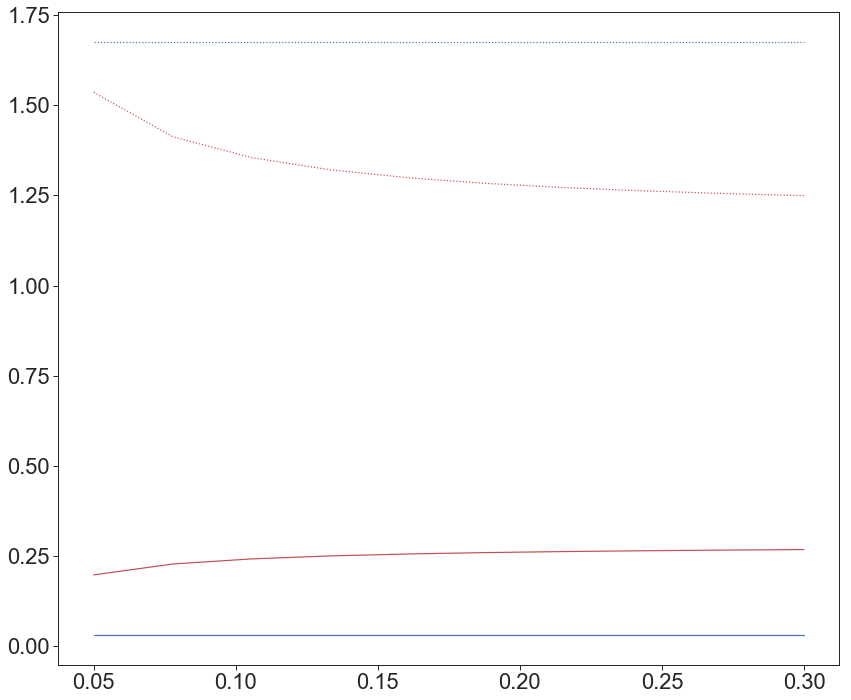

  Parameter        Range    Substrate   Fw/Fa slope  Fw/Fa r2  Fb/Fa slope  \
0     alpha  [0.05, 0.3]  Hydrophilic  3.027881e-18  0.001515     0.230275   
0     alpha  [0.05, 0.3]  Hydrophobic -9.689219e-17  0.003030    -0.940319   

   Fb/Fa r2  
0  0.771764  
0  0.771764  


In [33]:
#sensitivity analysis: alpha

# alpha = 0.1
Dp_Dh = 50
asp_ratio = 10 #L/Dh

y_fa = 1 #fluid-air interfacial tension (N/m) https://pubs.acs.org/doi/10.1021/la960800g
y_fw = 2 #fluid-water interfacial tension (N/m)
y_wa = 3 #water surface tension (N/m)
phi_f = 2 #fluid size parameter
phi_b = 1.6 #bubble size parameter

s_f = 1 #fluid size scale Vf = 4/3*pi*s_f^3

alpha_array = np.linspace(0.05,0.3,10)

#hydrophilic
theta_fa = 6 #fluid-substrate contact angle in air
theta_wa = 20 #water-substrate contact angle in air


df = pd.DataFrame()
# Fa_array = []
# Fw_array = []
# Fb_array = []
# Fbo_array = []
for alpha in alpha_array:
    Fa, Fw, Fb, Fbo = get_adhesion_array(Dp_Dh, alpha, asp_ratio, y_fa, y_fw, y_wa,
                                         theta_fa, theta_wa, phi_f, phi_b, s_f)
    df_temp = pd.DataFrame({'alpha': [alpha],
                            'Force_air':[Fa],
                            'Force_water':[Fw],
                            'Force_bubble':[Fb]})
    df = df.append(df_temp)

#linear regression 
w_slope, w_intercept, w_r, w_p, w_se = linregress(df['alpha'], df['Force_water']/df['Force_air'])
b_slope, b_intercept, b_r, b_p, b_se = linregress(df['alpha'], df['Force_bubble']/df['Force_air'])

print("Water/Air", "Slope:", w_slope, "R2:", w_r**2)
print("Bubble/Air", "Slope:", b_slope, "R2:", b_r**2)
df_sens_temp = pd.DataFrame({'Parameter': ['alpha'],
                            'Range': [str([alpha_array[0], alpha_array[-1]])],
                            'Substrate': ['Hydrophilic'],
                            'Fw/Fa slope': [w_slope],
                            'Fw/Fa r2': [w_r**2],
                            'Fb/Fa slope': [b_slope],
                            'Fb/Fa r2': [b_r**2]})
df_sens = df_sens.append(df_sens_temp)

#plots
plt.plot(df['alpha'], df['Force_water']/df['Force_air'], '-b')
plt.plot(df['alpha'], df['Force_bubble']/df['Force_air'], '-r')

#hydrophobic
theta_fa = 56 #fluid-substrate contact angle in air
theta_wa = 93 #water-substrate contact angle in air

df = pd.DataFrame()
# Fa_array = []
# Fw_array = []
# Fb_array = []
# Fbo_array = []
for alpha in alpha_array:
    Fa, Fw, Fb, Fbo = get_adhesion_array(Dp_Dh, alpha, asp_ratio, y_fa, y_fw, y_wa,
                                         theta_fa, theta_wa, phi_f, phi_b, s_f)
    df_temp = pd.DataFrame({'alpha': [alpha],
                            'Force_air':[Fa],
                            'Force_water':[Fw],
                            'Force_bubble':[Fb]})
    df = df.append(df_temp)

#linear regression 
w_slope, w_intercept, w_r, w_p, w_se = linregress(df['alpha'], df['Force_water']/df['Force_air'])
b_slope, b_intercept, b_r, b_p, b_se = linregress(df['alpha'], df['Force_bubble']/df['Force_air'])

print("Water/Air", "Slope:", w_slope, "R2:", w_r**2)
print("Bubble/Air", "Slope:", b_slope, "R2:", b_r**2)
df_sens_temp = pd.DataFrame({'Parameter': ['alpha'],
                            'Range': [str([alpha_array[0], alpha_array[-1]])],
                            'Substrate': ['Hydrophobic'],
                            'Fw/Fa slope': [w_slope],
                            'Fw/Fa r2': [w_r**2],
                            'Fb/Fa slope': [b_slope],
                            'Fb/Fa r2': [b_r**2]})
df_sens = df_sens.append(df_sens_temp)

#plots
plt.plot(df['alpha'], df['Force_water']/df['Force_air'], ':b')
plt.plot(df['alpha'], df['Force_bubble']/df['Force_air'], ':r')

plt.show()
print(df_sens)

Water/Air Slope: -8.831319514063742e-20 R2: 0.1484848484848484
Bubble/Air Slope: 0.012776790870420293 R2: 0.9725329615277738
Water/Air Slope: -5.652044489000793e-18 R2: 0.1484848484848483
Bubble/Air Slope: -0.015124815806271437 R2: 0.9822032508170242


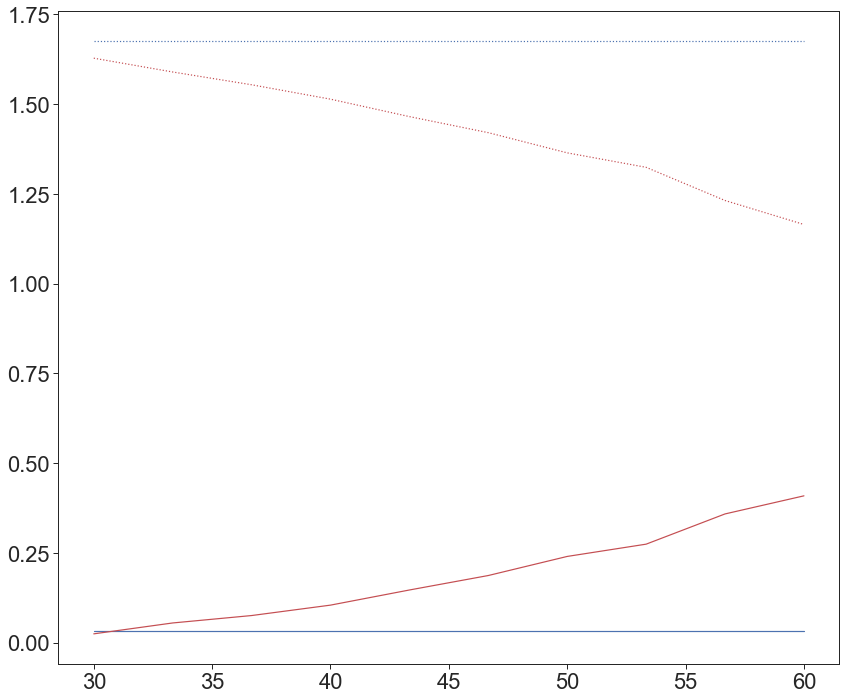

  Parameter         Range    Substrate   Fw/Fa slope  Fw/Fa r2  Fb/Fa slope  \
0     alpha   [0.05, 0.3]  Hydrophilic  3.027881e-18  0.001515     0.230275   
0     alpha   [0.05, 0.3]  Hydrophobic -9.689219e-17  0.003030    -0.940319   
0     Dp_Dh  [30.0, 60.0]  Hydrophilic -8.831320e-20  0.148485     0.012777   
0     Dp_Dh  [30.0, 60.0]  Hydrophobic -5.652044e-18  0.148485    -0.015125   

   Fb/Fa r2  
0  0.771764  
0  0.771764  
0  0.972533  
0  0.982203  


In [34]:
#sensitivity analysis: Dp_Dh

alpha = 0.1
# Dp_Dh = 50
asp_ratio = 10 #L/Dh

y_fa = 1 #fluid-air interfacial tension (N/m) https://pubs.acs.org/doi/10.1021/la960800g
y_fw = 2 #fluid-water interfacial tension (N/m)
y_wa = 3 #water surface tension (N/m)
phi_f = 2 #fluid size parameter
phi_b = 1.6 #bubble size parameter

s_f = 1 #fluid size scale Vf = 4/3*pi*s_f^3

Dp_Dh_array = np.linspace(30,60,10)

#hydrophilic
theta_fa = 6 #fluid-substrate contact angle in air
theta_wa = 20 #water-substrate contact angle in air


df = pd.DataFrame()

for Dp_Dh in Dp_Dh_array:
    Fa, Fw, Fb, Fbo = get_adhesion_array(Dp_Dh, alpha, asp_ratio, y_fa, y_fw, y_wa,
                                         theta_fa, theta_wa, phi_f, phi_b, s_f)
    df_temp = pd.DataFrame({'Dp_Dh': [Dp_Dh],
                            'Force_air':[Fa],
                            'Force_water':[Fw],
                            'Force_bubble':[Fb]})
    df = df.append(df_temp)

#linear regression 
w_slope, w_intercept, w_r, w_p, w_se = linregress(df['Dp_Dh'], df['Force_water']/df['Force_air'])
b_slope, b_intercept, b_r, b_p, b_se = linregress(df['Dp_Dh'], df['Force_bubble']/df['Force_air'])

print("Water/Air", "Slope:", w_slope, "R2:", w_r**2)
print("Bubble/Air", "Slope:", b_slope, "R2:", b_r**2)
df_sens_temp = pd.DataFrame({'Parameter': ['Dp_Dh'],
                            'Range': [str([Dp_Dh_array[0], Dp_Dh_array[-1]])],
                            'Substrate': ['Hydrophilic'],
                            'Fw/Fa slope': [w_slope],
                            'Fw/Fa r2': [w_r**2],
                            'Fb/Fa slope': [b_slope],
                            'Fb/Fa r2': [b_r**2]})
df_sens = df_sens.append(df_sens_temp)

#plots
plt.plot(df['Dp_Dh'], df['Force_water']/df['Force_air'], '-b')
plt.plot(df['Dp_Dh'], df['Force_bubble']/df['Force_air'], '-r')

#hydrophobic
theta_fa = 56 #fluid-substrate contact angle in air
theta_wa = 93 #water-substrate contact angle in air

df = pd.DataFrame()

for Dp_Dh in Dp_Dh_array:
    Fa, Fw, Fb, Fbo = get_adhesion_array(Dp_Dh, alpha, asp_ratio, y_fa, y_fw, y_wa,
                                         theta_fa, theta_wa, phi_f, phi_b, s_f)
    df_temp = pd.DataFrame({'Dp_Dh': [Dp_Dh],
                            'Force_air':[Fa],
                            'Force_water':[Fw],
                            'Force_bubble':[Fb]})
    df = df.append(df_temp)

#linear regression 
w_slope, w_intercept, w_r, w_p, w_se = linregress(df['Dp_Dh'], df['Force_water']/df['Force_air'])
b_slope, b_intercept, b_r, b_p, b_se = linregress(df['Dp_Dh'], df['Force_bubble']/df['Force_air'])

print("Water/Air", "Slope:", w_slope, "R2:", w_r**2)
print("Bubble/Air", "Slope:", b_slope, "R2:", b_r**2)
df_sens_temp = pd.DataFrame({'Parameter': ['Dp_Dh'],
                            'Range': [str([Dp_Dh_array[0], Dp_Dh_array[-1]])],
                            'Substrate': ['Hydrophobic'],
                            'Fw/Fa slope': [w_slope],
                            'Fw/Fa r2': [w_r**2],
                            'Fb/Fa slope': [b_slope],
                            'Fb/Fa r2': [b_r**2]})
df_sens = df_sens.append(df_sens_temp)

#plots
plt.plot(df['Dp_Dh'], df['Force_water']/df['Force_air'], ':b')
plt.plot(df['Dp_Dh'], df['Force_bubble']/df['Force_air'], ':r')

plt.show()
print(df_sens)

Water/Air Slope: 0.0 R2: 0.0
Bubble/Air Slope: -0.05273169692588055 R2: 0.911074834502824
Water/Air Slope: 0.0 R2: 0.0
Bubble/Air Slope: 0.054114236237476854 R2: 0.8662884787108591


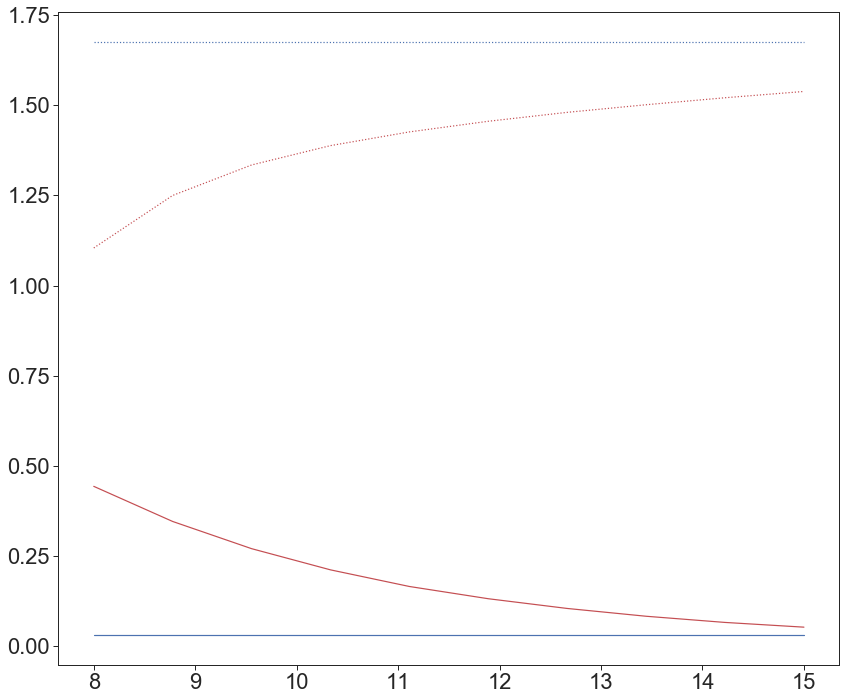

   Parameter         Range    Substrate   Fw/Fa slope  Fw/Fa r2  Fb/Fa slope  \
0      alpha   [0.05, 0.3]  Hydrophilic  3.027881e-18  0.001515     0.230275   
0      alpha   [0.05, 0.3]  Hydrophobic -9.689219e-17  0.003030    -0.940319   
0      Dp_Dh  [30.0, 60.0]  Hydrophilic -8.831320e-20  0.148485     0.012777   
0      Dp_Dh  [30.0, 60.0]  Hydrophobic -5.652044e-18  0.148485    -0.015125   
0  asp_ratio   [8.0, 15.0]  Hydrophilic  0.000000e+00  0.000000    -0.052732   
0  asp_ratio   [8.0, 15.0]  Hydrophobic  0.000000e+00  0.000000     0.054114   

   Fb/Fa r2  
0  0.771764  
0  0.771764  
0  0.972533  
0  0.982203  
0  0.911075  
0  0.866288  


In [35]:
#sensitivity analysis: asp_ratio

alpha = 0.1
Dp_Dh = 50
# asp_ratio = 10 #L/Dh

y_fa = 1 #fluid-air interfacial tension (N/m) https://pubs.acs.org/doi/10.1021/la960800g
y_fw = 2 #fluid-water interfacial tension (N/m)
y_wa = 3 #water surface tension (N/m)
phi_f = 2 #fluid size parameter
phi_b = 1.6 #bubble size parameter

s_f = 1 #fluid size scale Vf = 4/3*pi*s_f^3

asp_ratio_array = np.linspace(8,15,10)

#hydrophilic
theta_fa = 6 #fluid-substrate contact angle in air
theta_wa = 20 #water-substrate contact angle in air

df = pd.DataFrame()

for asp_ratio in asp_ratio_array:
    Fa, Fw, Fb, Fbo = get_adhesion_array(Dp_Dh, alpha, asp_ratio, y_fa, y_fw, y_wa,
                                         theta_fa, theta_wa, phi_f, phi_b, s_f)
    df_temp = pd.DataFrame({'Aspect_ratio': [asp_ratio],
                            'Force_air':[Fa],
                            'Force_water':[Fw],
                            'Force_bubble':[Fb]})
    df = df.append(df_temp)

#linear regression 
w_slope, w_intercept, w_r, w_p, w_se = linregress(df['Aspect_ratio'], df['Force_water']/df['Force_air'])
b_slope, b_intercept, b_r, b_p, b_se = linregress(df['Aspect_ratio'], df['Force_bubble']/df['Force_air'])

print("Water/Air", "Slope:", w_slope, "R2:", w_r**2)
print("Bubble/Air", "Slope:", b_slope, "R2:", b_r**2)
df_sens_temp = pd.DataFrame({'Parameter': ['asp_ratio'],
                            'Range': [str([asp_ratio_array[0], asp_ratio_array[-1]])],
                            'Substrate': ['Hydrophilic'],
                            'Fw/Fa slope': [w_slope],
                            'Fw/Fa r2': [w_r**2],
                            'Fb/Fa slope': [b_slope],
                            'Fb/Fa r2': [b_r**2]})
df_sens = df_sens.append(df_sens_temp)

#plots
plt.plot(df['Aspect_ratio'], df['Force_water']/df['Force_air'], '-b')
plt.plot(df['Aspect_ratio'], df['Force_bubble']/df['Force_air'], '-r')

#hydrophobic
theta_fa = 56 #fluid-substrate contact angle in air
theta_wa = 93 #water-substrate contact angle in air

df = pd.DataFrame()

for asp_ratio in asp_ratio_array:
    Fa, Fw, Fb, Fbo = get_adhesion_array(Dp_Dh, alpha, asp_ratio, y_fa, y_fw, y_wa,
                                         theta_fa, theta_wa, phi_f, phi_b, s_f)
    df_temp = pd.DataFrame({'Aspect_ratio': [asp_ratio],
                            'Force_air':[Fa],
                            'Force_water':[Fw],
                            'Force_bubble':[Fb]})
    df = df.append(df_temp)

#linear regression 
w_slope, w_intercept, w_r, w_p, w_se = linregress(df['Aspect_ratio'], df['Force_water']/df['Force_air'])
b_slope, b_intercept, b_r, b_p, b_se = linregress(df['Aspect_ratio'], df['Force_bubble']/df['Force_air'])

print("Water/Air", "Slope:", w_slope, "R2:", w_r**2)
print("Bubble/Air", "Slope:", b_slope, "R2:", b_r**2)
df_sens_temp = pd.DataFrame({'Parameter': ['asp_ratio'],
                            'Range': [str([asp_ratio_array[0], asp_ratio_array[-1]])],
                            'Substrate': ['Hydrophobic'],
                            'Fw/Fa slope': [w_slope],
                            'Fw/Fa r2': [w_r**2],
                            'Fb/Fa slope': [b_slope],
                            'Fb/Fa r2': [b_r**2]})
df_sens = df_sens.append(df_sens_temp)

#plots
plt.plot(df['Aspect_ratio'], df['Force_water']/df['Force_air'], ':b')
plt.plot(df['Aspect_ratio'], df['Force_bubble']/df['Force_air'], ':r')

plt.show()
print(df_sens)

Water/Air Slope: -0.20107285809075343 R2: 0.8566637214416452
Bubble/Air Slope: -0.24328611512503753 R2: 0.9427489313664021
Water/Air Slope: 0.04108363875543244 R2: 0.9999991081008622
Bubble/Air Slope: 0.06874800423601769 R2: 0.9999999912949709


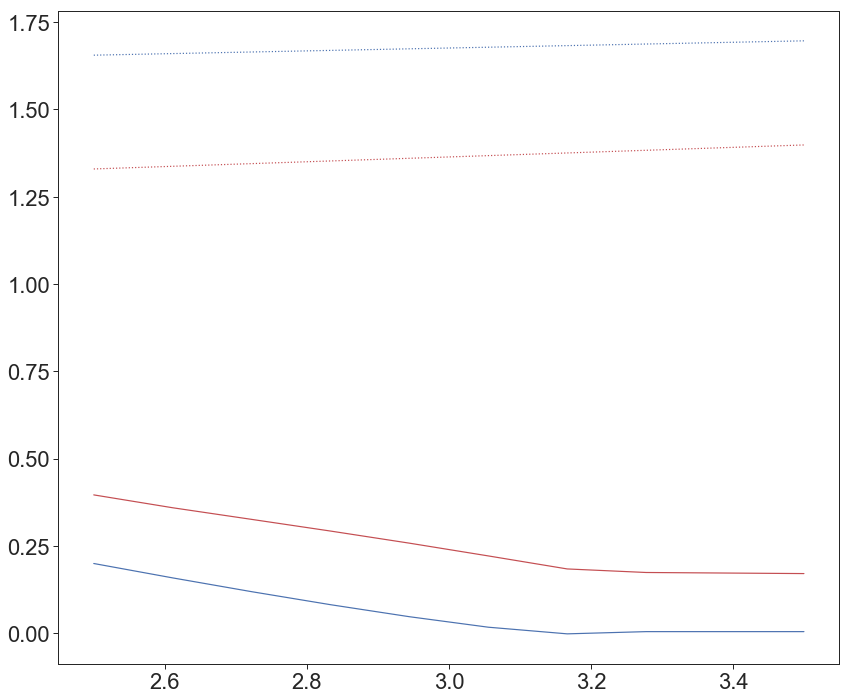

   Parameter         Range    Substrate   Fw/Fa slope  Fw/Fa r2  Fb/Fa slope  \
0      alpha   [0.05, 0.3]  Hydrophilic  3.027881e-18  0.001515     0.230275   
0      alpha   [0.05, 0.3]  Hydrophobic -9.689219e-17  0.003030    -0.940319   
0      Dp_Dh  [30.0, 60.0]  Hydrophilic -8.831320e-20  0.148485     0.012777   
0      Dp_Dh  [30.0, 60.0]  Hydrophobic -5.652044e-18  0.148485    -0.015125   
0  asp_ratio   [8.0, 15.0]  Hydrophilic  0.000000e+00  0.000000    -0.052732   
0  asp_ratio   [8.0, 15.0]  Hydrophobic  0.000000e+00  0.000000     0.054114   
0       y_wa    [2.5, 3.5]  Hydrophilic -2.010729e-01  0.856664    -0.243286   
0       y_wa    [2.5, 3.5]  Hydrophobic  4.108364e-02  0.999999     0.068748   

   Fb/Fa r2  
0  0.771764  
0  0.771764  
0  0.972533  
0  0.982203  
0  0.911075  
0  0.866288  
0  0.942749  
0  1.000000  


In [36]:
#sensitivity analysis: y_wa

Dp_Dh = 50
alpha = 0.1
asp_ratio = 10 #L/Dh

y_fa = 1 #fluid-air interfacial tension (N/m) https://pubs.acs.org/doi/10.1021/la960800g
y_fw = 2 #fluid-water interfacial tension (N/m)
# y_wa = 3 #water surface tension (N/m)
phi_f = 2 #fluid size parameter
phi_b = 1.6 #bubble size parameter

s_f = 1 #fluid size scale Vf = 4/3*pi*s_f^3

y_wa_array = np.linspace(2.5,3.5,10)

#hydrophilic
theta_fa = 6 #fluid-substrate contact angle in air
theta_wa = 20 #water-substrate contact angle in air

df = pd.DataFrame()

for y_wa in y_wa_array:
    Fa, Fw, Fb, Fbo = get_adhesion_array(Dp_Dh, alpha, asp_ratio, y_fa, y_fw, y_wa,
                                         theta_fa, theta_wa, phi_f, phi_b, s_f)
    df_temp = pd.DataFrame({'Water-air_interfacial_tension': [y_wa],
                            'Force_air':[Fa],
                            'Force_water':[Fw],
                            'Force_bubble':[Fb]})
    df = df.append(df_temp)

#linear regression 
w_slope, w_intercept, w_r, w_p, w_se = linregress(df['Water-air_interfacial_tension'], 
                                                  df['Force_water']/df['Force_air'])
b_slope, b_intercept, b_r, b_p, b_se = linregress(df['Water-air_interfacial_tension'], 
                                                  df['Force_bubble']/df['Force_air'])

print("Water/Air", "Slope:", w_slope, "R2:", w_r**2)
print("Bubble/Air", "Slope:", b_slope, "R2:", b_r**2)
df_sens_temp = pd.DataFrame({'Parameter': ['y_wa'],
                            'Range': [str([y_wa_array[0], y_wa_array[-1]])],
                            'Substrate': ['Hydrophilic'],
                            'Fw/Fa slope': [w_slope],
                            'Fw/Fa r2': [w_r**2],
                            'Fb/Fa slope': [b_slope],
                            'Fb/Fa r2': [b_r**2]})
df_sens = df_sens.append(df_sens_temp)

#plots

plt.plot(df['Water-air_interfacial_tension'], df['Force_water']/df['Force_air'], '-b')
plt.plot(df['Water-air_interfacial_tension'], df['Force_bubble']/df['Force_air'], '-r')

#hydrophobic
theta_fa = 56 #fluid-substrate contact angle in air
theta_wa = 93 #water-substrate contact angle in air

df = pd.DataFrame()

for y_wa in y_wa_array:
    Fa, Fw, Fb, Fbo = get_adhesion_array(Dp_Dh, alpha, asp_ratio, y_fa, y_fw, y_wa,
                                         theta_fa, theta_wa, phi_f, phi_b, s_f)
    df_temp = pd.DataFrame({'Water-air_interfacial_tension': [y_wa],
                            'Force_air':[Fa],
                            'Force_water':[Fw],
                            'Force_bubble':[Fb]})
    df = df.append(df_temp)

#linear regression 
w_slope, w_intercept, w_r, w_p, w_se = linregress(df['Water-air_interfacial_tension'], 
                                                  df['Force_water']/df['Force_air'])
b_slope, b_intercept, b_r, b_p, b_se = linregress(df['Water-air_interfacial_tension'], 
                                                  df['Force_bubble']/df['Force_air'])

print("Water/Air", "Slope:", w_slope, "R2:", w_r**2)
print("Bubble/Air", "Slope:", b_slope, "R2:", b_r**2)
df_sens_temp = pd.DataFrame({'Parameter': ['y_wa'],
                            'Range': [str([y_wa_array[0], y_wa_array[-1]])],
                            'Substrate': ['Hydrophobic'],
                            'Fw/Fa slope': [w_slope],
                            'Fw/Fa r2': [w_r**2],
                            'Fb/Fa slope': [b_slope],
                            'Fb/Fa r2': [b_r**2]})
df_sens = df_sens.append(df_sens_temp)

#plots

plt.plot(df['Water-air_interfacial_tension'], df['Force_water']/df['Force_air'], ':b')
plt.plot(df['Water-air_interfacial_tension'], df['Force_bubble']/df['Force_air'], ':r')

plt.show()
print(df_sens)

Water/Air Slope: 0.20127039230268107 R2: 0.8624609443995606
Bubble/Air Slope: 0.19038567748037044 R2: 0.8937363459985267
Water/Air Slope: 0.5562704612245684 R2: 0.9999875241330297
Bubble/Air Slope: 0.15664182300874951 R2: 0.9999956131437763


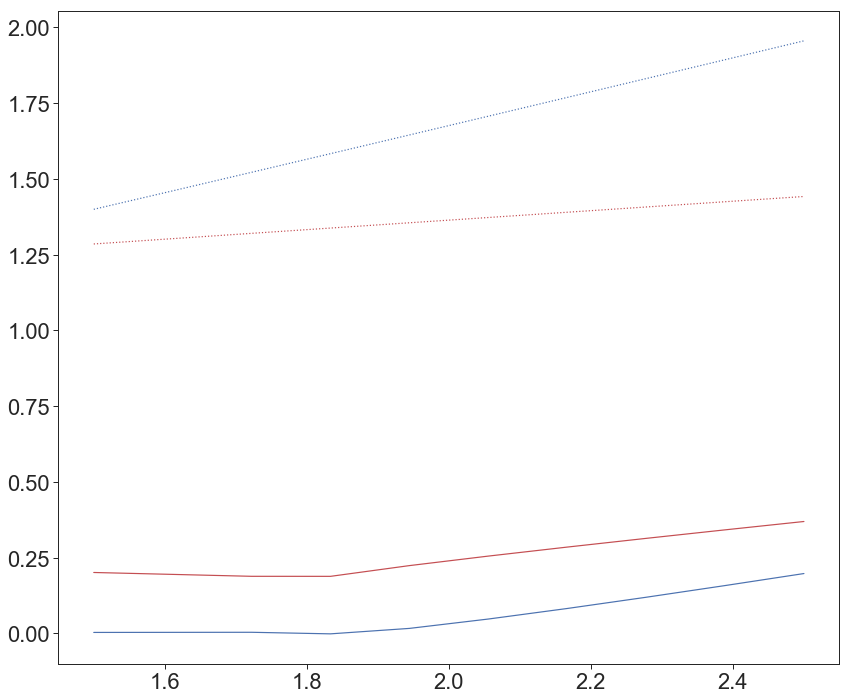

   Parameter         Range    Substrate   Fw/Fa slope  Fw/Fa r2  Fb/Fa slope  \
0      alpha   [0.05, 0.3]  Hydrophilic  3.027881e-18  0.001515     0.230275   
0      alpha   [0.05, 0.3]  Hydrophobic -9.689219e-17  0.003030    -0.940319   
0      Dp_Dh  [30.0, 60.0]  Hydrophilic -8.831320e-20  0.148485     0.012777   
0      Dp_Dh  [30.0, 60.0]  Hydrophobic -5.652044e-18  0.148485    -0.015125   
0  asp_ratio   [8.0, 15.0]  Hydrophilic  0.000000e+00  0.000000    -0.052732   
0  asp_ratio   [8.0, 15.0]  Hydrophobic  0.000000e+00  0.000000     0.054114   
0       y_wa    [2.5, 3.5]  Hydrophilic -2.010729e-01  0.856664    -0.243286   
0       y_wa    [2.5, 3.5]  Hydrophobic  4.108364e-02  0.999999     0.068748   
0       y_fw    [1.5, 2.5]  Hydrophilic  2.012704e-01  0.862461     0.190386   
0       y_fw    [1.5, 2.5]  Hydrophobic  5.562705e-01  0.999988     0.156642   

   Fb/Fa r2  
0  0.771764  
0  0.771764  
0  0.972533  
0  0.982203  
0  0.911075  
0  0.866288  
0  0.942749  
0  1.00

In [37]:
#sensitivity analysis: y_fw

Dp_Dh = 50
alpha = 0.1
asp_ratio = 10 #L/Dh

y_fa = 1 #fluid-air interfacial tension (N/m) https://pubs.acs.org/doi/10.1021/la960800g
# y_fw = 2 #fluid-water interfacial tension (N/m)
y_wa = 3 #water surface tension (N/m)
phi_f = 2 #fluid size parameter
phi_b = 1.6 #bubble size parameter

s_f = 1 #fluid size scale Vf = 4/3*pi*s_f^3

y_fw_array = np.linspace(1.5,2.5,10)

#hydrophilic
theta_fa = 6 #fluid-substrate contact angle in air
theta_wa = 20 #water-substrate contact angle in air

df = pd.DataFrame()

for y_fw in y_fw_array:
    Fa, Fw, Fb, Fbo = get_adhesion_array(Dp_Dh, alpha, asp_ratio, y_fa, y_fw, y_wa,
                                         theta_fa, theta_wa, phi_f, phi_b, s_f)
    df_temp = pd.DataFrame({'Fluid-water_interfacial_tension': [y_fw],
                            'Force_air':[Fa],
                            'Force_water':[Fw],
                            'Force_bubble':[Fb]})
    df = df.append(df_temp)

#linear regression 
w_slope, w_intercept, w_r, w_p, w_se = linregress(df['Fluid-water_interfacial_tension'], 
                                                  df['Force_water']/df['Force_air'])
b_slope, b_intercept, b_r, b_p, b_se = linregress(df['Fluid-water_interfacial_tension'], 
                                                  df['Force_bubble']/df['Force_air'])

print("Water/Air", "Slope:", w_slope, "R2:", w_r**2)
print("Bubble/Air", "Slope:", b_slope, "R2:", b_r**2)
df_sens_temp = pd.DataFrame({'Parameter': ['y_fw'],
                            'Range': [str([y_fw_array[0], y_fw_array[-1]])],
                            'Substrate': ['Hydrophilic'],
                            'Fw/Fa slope': [w_slope],
                            'Fw/Fa r2': [w_r**2],
                            'Fb/Fa slope': [b_slope],
                            'Fb/Fa r2': [b_r**2]})
df_sens = df_sens.append(df_sens_temp)

#plots
plt.plot(df['Fluid-water_interfacial_tension'], df['Force_water']/df['Force_air'], '-b')
plt.plot(df['Fluid-water_interfacial_tension'], df['Force_bubble']/df['Force_air'], '-r')

#hydrophobic
theta_fa = 56 #fluid-substrate contact angle in air
theta_wa = 93 #water-substrate contact angle in air

df = pd.DataFrame()

for y_fw in y_fw_array:
    Fa, Fw, Fb, Fbo = get_adhesion_array(Dp_Dh, alpha, asp_ratio, y_fa, y_fw, y_wa,
                                         theta_fa, theta_wa, phi_f, phi_b, s_f)
    df_temp = pd.DataFrame({'Fluid-water_interfacial_tension': [y_fw],
                            'Force_air':[Fa],
                            'Force_water':[Fw],
                            'Force_bubble':[Fb]})
    df = df.append(df_temp)

#linear regression 
w_slope, w_intercept, w_r, w_p, w_se = linregress(df['Fluid-water_interfacial_tension'], 
                                                  df['Force_water']/df['Force_air'])
b_slope, b_intercept, b_r, b_p, b_se = linregress(df['Fluid-water_interfacial_tension'], 
                                                  df['Force_bubble']/df['Force_air'])

print("Water/Air", "Slope:", w_slope, "R2:", w_r**2)
print("Bubble/Air", "Slope:", b_slope, "R2:", b_r**2)
df_sens_temp = pd.DataFrame({'Parameter': ['y_fw'],
                            'Range': [str([y_fw_array[0], y_fw_array[-1]])],
                            'Substrate': ['Hydrophobic'],
                            'Fw/Fa slope': [w_slope],
                            'Fw/Fa r2': [w_r**2],
                            'Fb/Fa slope': [b_slope],
                            'Fb/Fa r2': [b_r**2]})
df_sens = df_sens.append(df_sens_temp)

#plots
plt.plot(df['Fluid-water_interfacial_tension'], df['Force_water']/df['Force_air'], ':b')
plt.plot(df['Fluid-water_interfacial_tension'], df['Force_bubble']/df['Force_air'], ':r')

plt.show()
print(df_sens)

Water/Air Slope: 0.012908931887695171 R2: 0.45236489271117725
Bubble/Air Slope: 0.06183125597201161 R2: 0.07942549583490179
Water/Air Slope: 0.0767045976416658 R2: 0.9840693910501345
Bubble/Air Slope: -0.30633404611311366 R2: 0.9655321050389519


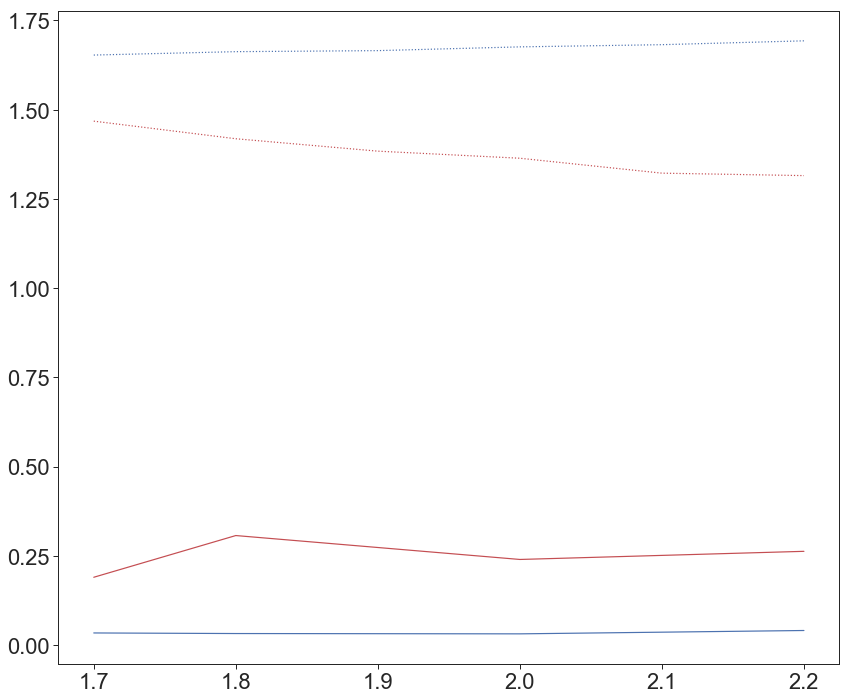

   Parameter         Range    Substrate   Fw/Fa slope  Fw/Fa r2  Fb/Fa slope  \
0      alpha   [0.05, 0.3]  Hydrophilic  3.027881e-18  0.001515     0.230275   
0      alpha   [0.05, 0.3]  Hydrophobic -9.689219e-17  0.003030    -0.940319   
0      Dp_Dh  [30.0, 60.0]  Hydrophilic -8.831320e-20  0.148485     0.012777   
0      Dp_Dh  [30.0, 60.0]  Hydrophobic -5.652044e-18  0.148485    -0.015125   
0  asp_ratio   [8.0, 15.0]  Hydrophilic  0.000000e+00  0.000000    -0.052732   
0  asp_ratio   [8.0, 15.0]  Hydrophobic  0.000000e+00  0.000000     0.054114   
0       y_wa    [2.5, 3.5]  Hydrophilic -2.010729e-01  0.856664    -0.243286   
0       y_wa    [2.5, 3.5]  Hydrophobic  4.108364e-02  0.999999     0.068748   
0       y_fw    [1.5, 2.5]  Hydrophilic  2.012704e-01  0.862461     0.190386   
0       y_fw    [1.5, 2.5]  Hydrophobic  5.562705e-01  0.999988     0.156642   
0      phi_f    [1.7, 2.2]  Hydrophilic  1.290893e-02  0.452365     0.061831   
0      phi_f    [1.7, 2.2]  Hydrophobic 

In [38]:
#sensitivity analysis: phi_f

Dp_Dh = 50
alpha = 0.1
asp_ratio = 10 #L/Dh

y_fa = 1 #fluid-air interfacial tension (N/m) https://pubs.acs.org/doi/10.1021/la960800g
y_fw = 2 #fluid-water interfacial tension (N/m)
y_wa = 3 #water surface tension (N/m)
# phi_f = 2 #fluid size parameter
phi_b = 1.6 #bubble size parameter

s_f = 1 #fluid size scale Vf = 4/3*pi*s_f^3

phi_f_array = [1.7, 1.8, 2, 2.2]

#hydrophilic
theta_fa = 6 #fluid-substrate contact angle in air
theta_wa = 20 #water-substrate contact angle in air

df = pd.DataFrame()

for phi_f in phi_f_array:
    Fa, Fw, Fb, Fbo = get_adhesion_array(Dp_Dh, alpha, asp_ratio, y_fa, y_fw, y_wa,
                                         theta_fa, theta_wa, phi_f, phi_b, s_f)
    df_temp = pd.DataFrame({'Fluid_size_param': [phi_f],
                            'Force_air':[Fa],
                            'Force_water':[Fw],
                            'Force_bubble':[Fb]})
    df = df.append(df_temp)

#linear regression 
w_slope, w_intercept, w_r, w_p, w_se = linregress(df['Fluid_size_param'], 
                                                  df['Force_water']/df['Force_air'])
b_slope, b_intercept, b_r, b_p, b_se = linregress(df['Fluid_size_param'], 
                                                  df['Force_bubble']/df['Force_air'])

print("Water/Air", "Slope:", w_slope, "R2:", w_r**2)
print("Bubble/Air", "Slope:", b_slope, "R2:", b_r**2)
df_sens_temp = pd.DataFrame({'Parameter': ['phi_f'],
                            'Range': [str([phi_f_array[0], phi_f_array[-1]])],
                            'Substrate': ['Hydrophilic'],
                            'Fw/Fa slope': [w_slope],
                            'Fw/Fa r2': [w_r**2],
                            'Fb/Fa slope': [b_slope],
                            'Fb/Fa r2': [b_r**2]})
df_sens = df_sens.append(df_sens_temp)

#plots
plt.plot(df['Fluid_size_param'], df['Force_water']/df['Force_air'], '-b')
plt.plot(df['Fluid_size_param'], df['Force_bubble']/df['Force_air'], '-r')

#hydrophobic
theta_fa = 56 #fluid-substrate contact angle in air
theta_wa = 93 #water-substrate contact angle in air

phi_f_array = [1.7, 1.8, 1.9, 2, 2.1, 2.2]

df = pd.DataFrame()

for phi_f in phi_f_array:
    Fa, Fw, Fb, Fbo = get_adhesion_array(Dp_Dh, alpha, asp_ratio, y_fa, y_fw, y_wa,
                                         theta_fa, theta_wa, phi_f, phi_b, s_f)
    df_temp = pd.DataFrame({'Fluid_size_param': [phi_f],
                            'Force_air':[Fa],
                            'Force_water':[Fw],
                            'Force_bubble':[Fb]})
    df = df.append(df_temp)

#linear regression 
w_slope, w_intercept, w_r, w_p, w_se = linregress(df['Fluid_size_param'], 
                                                  df['Force_water']/df['Force_air'])
b_slope, b_intercept, b_r, b_p, b_se = linregress(df['Fluid_size_param'], 
                                                  df['Force_bubble']/df['Force_air'])

print("Water/Air", "Slope:", w_slope, "R2:", w_r**2)
print("Bubble/Air", "Slope:", b_slope, "R2:", b_r**2)
df_sens_temp = pd.DataFrame({'Parameter': ['phi_f'],
                            'Range': [str([phi_f_array[0], phi_f_array[-1]])],
                            'Substrate': ['Hydrophobic'],
                            'Fw/Fa slope': [w_slope],
                            'Fw/Fa r2': [w_r**2],
                            'Fb/Fa slope': [b_slope],
                            'Fb/Fa r2': [b_r**2]})
df_sens = df_sens.append(df_sens_temp)

#plots
plt.plot(df['Fluid_size_param'], df['Force_water']/df['Force_air'], ':b')
plt.plot(df['Fluid_size_param'], df['Force_bubble']/df['Force_air'], ':r')

plt.show()
print(df_sens)

Water/Air Slope: 0.0 R2: 0.0
Bubble/Air Slope: -1.1413606468360291 R2: 0.8851092108656494
Water/Air Slope: 0.0 R2: 0.0
Bubble/Air Slope: 1.4604854944661794 R2: 0.9776377832434152


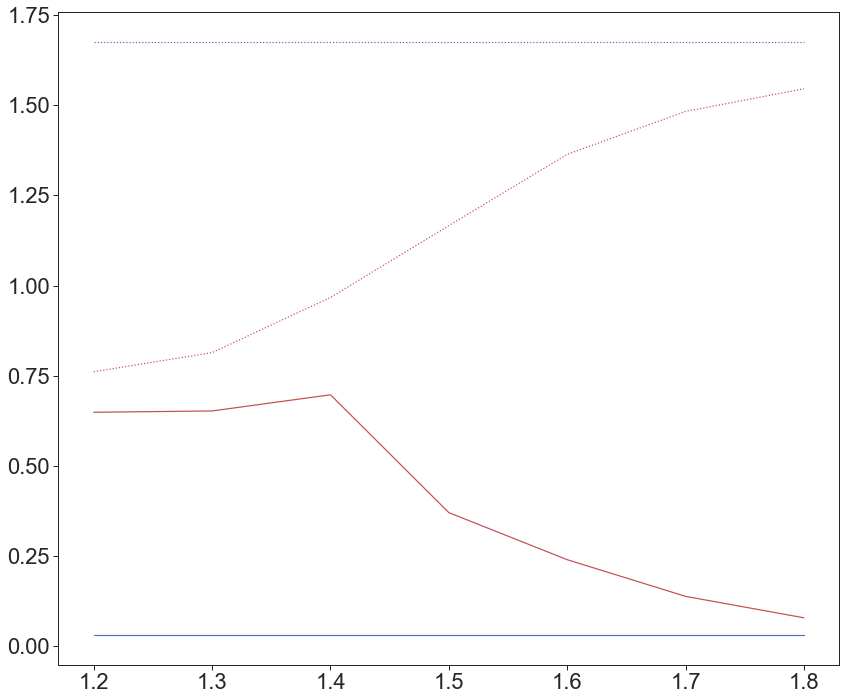

   Parameter         Range    Substrate   Fw/Fa slope  Fw/Fa r2  Fb/Fa slope  \
0      alpha   [0.05, 0.3]  Hydrophilic  3.027881e-18  0.001515     0.230275   
0      alpha   [0.05, 0.3]  Hydrophobic -9.689219e-17  0.003030    -0.940319   
0      Dp_Dh  [30.0, 60.0]  Hydrophilic -8.831320e-20  0.148485     0.012777   
0      Dp_Dh  [30.0, 60.0]  Hydrophobic -5.652044e-18  0.148485    -0.015125   
0  asp_ratio   [8.0, 15.0]  Hydrophilic  0.000000e+00  0.000000    -0.052732   
0  asp_ratio   [8.0, 15.0]  Hydrophobic  0.000000e+00  0.000000     0.054114   
0       y_wa    [2.5, 3.5]  Hydrophilic -2.010729e-01  0.856664    -0.243286   
0       y_wa    [2.5, 3.5]  Hydrophobic  4.108364e-02  0.999999     0.068748   
0       y_fw    [1.5, 2.5]  Hydrophilic  2.012704e-01  0.862461     0.190386   
0       y_fw    [1.5, 2.5]  Hydrophobic  5.562705e-01  0.999988     0.156642   
0      phi_f    [1.7, 2.2]  Hydrophilic  1.290893e-02  0.452365     0.061831   
0      phi_f    [1.7, 2.2]  Hydrophobic 

In [39]:
#sensitivity analysis: phi_b

Dp_Dh = 50
alpha = 0.1
asp_ratio = 10 #L/Dh

y_fa = 1 #fluid-air interfacial tension (N/m) https://pubs.acs.org/doi/10.1021/la960800g
y_fw = 2 #fluid-water interfacial tension (N/m)
y_wa = 3 #water surface tension (N/m)
phi_f = 2 #fluid size parameter
# phi_b = 1.6 #bubble size parameter

s_f = 1 #fluid size scale Vf = 4/3*pi*s_f^3

phi_b_array = [1.2,1.3,1.4,1.5,1.6,1.7,1.8]

theta_fa = 6 #fluid-substrate contact angle in air
theta_wa = 20 #water-substrate contact angle in air

df = pd.DataFrame()

for phi_b in phi_b_array:
    Fa, Fw, Fb, Fbo = get_adhesion_array(Dp_Dh, alpha, asp_ratio, y_fa, y_fw, y_wa,
                                         theta_fa, theta_wa, phi_f, phi_b, s_f)
    df_temp = pd.DataFrame({'Bubble_size_param': [phi_b],
                            'Force_air':[Fa],
                            'Force_water':[Fw],
                            'Force_bubble':[Fb]})
    df = df.append(df_temp)

#linear regression 
w_slope, w_intercept, w_r, w_p, w_se = linregress(df['Bubble_size_param'], 
                                                  df['Force_water']/df['Force_air'])
b_slope, b_intercept, b_r, b_p, b_se = linregress(df['Bubble_size_param'], 
                                                  df['Force_bubble']/df['Force_air'])

print("Water/Air", "Slope:", w_slope, "R2:", w_r**2)
print("Bubble/Air", "Slope:", b_slope, "R2:", b_r**2)
df_sens_temp = pd.DataFrame({'Parameter': ['phi_b'],
                            'Range': [str([phi_b_array[0], phi_b_array[-1]])],
                            'Substrate': ['Hydrophilic'],
                            'Fw/Fa slope': [w_slope],
                            'Fw/Fa r2': [w_r**2],
                            'Fb/Fa slope': [b_slope],
                            'Fb/Fa r2': [b_r**2]})
df_sens = df_sens.append(df_sens_temp)

#plots
plt.plot(df['Bubble_size_param'], df['Force_water']/df['Force_air'], '-b')
plt.plot(df['Bubble_size_param'], df['Force_bubble']/df['Force_air'], '-r')

#hydrophobic
theta_fa = 56 #fluid-substrate contact angle in air
theta_wa = 93 #water-substrate contact angle in air

df = pd.DataFrame()

for phi_b in phi_b_array:
    Fa, Fw, Fb, Fbo = get_adhesion_array(Dp_Dh, alpha, asp_ratio, y_fa, y_fw, y_wa,
                                         theta_fa, theta_wa, phi_f, phi_b, s_f)
    df_temp = pd.DataFrame({'Bubble_size_param': [phi_b],
                            'Force_air':[Fa],
                            'Force_water':[Fw],
                            'Force_bubble':[Fb]})
    df = df.append(df_temp)

#linear regression 
w_slope, w_intercept, w_r, w_p, w_se = linregress(df['Bubble_size_param'], 
                                                  df['Force_water']/df['Force_air'])
b_slope, b_intercept, b_r, b_p, b_se = linregress(df['Bubble_size_param'], 
                                                  df['Force_bubble']/df['Force_air'])

print("Water/Air", "Slope:", w_slope, "R2:", w_r**2)
print("Bubble/Air", "Slope:", b_slope, "R2:", b_r**2)
df_sens_temp = pd.DataFrame({'Parameter': ['phi_b'],
                            'Range': [str([phi_b_array[0], phi_b_array[-1]])],
                            'Substrate': ['Hydrophobic'],
                            'Fw/Fa slope': [w_slope],
                            'Fw/Fa r2': [w_r**2],
                            'Fb/Fa slope': [b_slope],
                            'Fb/Fa r2': [b_r**2]})
df_sens = df_sens.append(df_sens_temp)

#plots
plt.plot(df['Bubble_size_param'], df['Force_water']/df['Force_air'], ':b')
plt.plot(df['Bubble_size_param'], df['Force_bubble']/df['Force_air'], ':r')

plt.show()
print(df_sens)

In [40]:
df_sens.to_excel('Sensitivity_analysis.xlsx')